In [2]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("🚀 Starting Time Series Regression with XGBoost")
print("="*60)

# 1. 데이터 로드
print("📁 Loading data...")
df = pd.read_csv("/workspace/rtu_data_full.csv")
print(f"Original data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# 2. 데이터 전처리 - Wide format으로 변환
print("\n🔄 Converting to wide format...")
df_indexed = df.set_index(['timestamp', 'localtime', 'module(equipment)'])
df_wide = df_indexed.unstack('module(equipment)')

# 컬럼명 정리
df_wide.columns = [f"{col[1][:col[1].index('(')]}_{col[0]}" for col in df_wide.columns]
df_wide = df_wide.reset_index()

print(f"Wide format shape: {df_wide.shape}")

# 3. Target 변수 생성 - 모든 공장의 activePower 평균
print("\n🎯 Creating target variable...")
equipment_list = ['1', '2', '3', '4', '5', '11', '12', '13', '14', '15', '16', '17', '18']
active_power_cols = [f'{eq}_activePower' for eq in equipment_list if f'{eq}_activePower' in df_wide.columns]

print(f"Available activePower columns: {len(active_power_cols)}")
for col in active_power_cols:
    print(f"  - {col}")

# Target 생성 (평균)
df_wide['target_activePower_mean'] = df_wide[active_power_cols].mean(axis=1)
print(f"Target variable created: target_activePower_mean")
print(f"Target range: {df_wide['target_activePower_mean'].min():.2f} ~ {df_wide['target_activePower_mean'].max():.2f}")

# 4. 시간 기반 feature 생성
print("\n⏰ Creating time-based features...")
df_wide['datetime'] = pd.to_datetime(df_wide['timestamp'], unit='ms')
df_wide['hour'] = df_wide['datetime'].dt.hour
df_wide['day'] = df_wide['datetime'].dt.day
df_wide['month'] = df_wide['datetime'].dt.month
df_wide['weekday'] = df_wide['datetime'].dt.weekday
df_wide['is_weekend'] = (df_wide['weekday'] >= 5).astype(int)
df_wide['hour_sin'] = np.sin(2 * np.pi * df_wide['hour'] / 24)
df_wide['hour_cos'] = np.cos(2 * np.pi * df_wide['hour'] / 24)
df_wide['day_sin'] = np.sin(2 * np.pi * df_wide['day'] / 31)
df_wide['day_cos'] = np.cos(2 * np.pi * df_wide['day'] / 31)

# 5. 데이터 정렬 및 결측치 처리
print("\n🔧 Sorting and cleaning data...")
df_wide = df_wide.sort_values('timestamp').reset_index(drop=True)
df_wide = df_wide.fillna(method='ffill').fillna(method='bfill')

print(f"Final data shape: {df_wide.shape}")
print(f"Date range: {df_wide['datetime'].min()} ~ {df_wide['datetime'].max()}")

# 6. Feature 선택 - 상관관계 기반 상위 20개
print("\n📊 Selecting top 20 features based on correlation...")
target_col = 'target_activePower_mean'

# 숫자형 컬럼만 선택 (timestamp, datetime 제외)
numeric_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
feature_candidates = [col for col in numeric_cols if col not in ['timestamp', 'localtime', target_col]]

print(f"Feature candidates: {len(feature_candidates)}")

# 상관관계 계산
correlation_start = time.time()
correlations = df_wide[feature_candidates + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
correlation_end = time.time()

print(f"Correlation analysis completed in {correlation_end - correlation_start:.2f}s")

# Target 제외하고 상위 20개 선택
top_20_features = [col for col in correlations.index if col != target_col][:20]

print(f"\n🏆 Top 20 features selected:")
print("="*50)
for i, feature in enumerate(top_20_features, 1):
    corr_value = correlations[feature]
    print(f"{i:2d}. {feature:<35} | {corr_value:.4f}")

# 7. 시계열 데이터 준비 (Many-to-Many)
def create_sequences_many_to_many(data, features, target, window_size, pred_size):
    """
    Many-to-Many 시계열 시퀀스 생성
    window_size: 입력 시퀀스 길이
    pred_size: 예측 시퀀스 길이
    """
    print(f"\n🔄 Creating Many-to-Many sequences...")
    print(f"   Input window: {window_size} timesteps")
    print(f"   Output window: {pred_size} timesteps")
    
    X_data = data[features].values
    y_data = data[target].values
    
    total_samples = len(data) - window_size - pred_size + 1
    
    X = np.zeros((total_samples, window_size, len(features)))
    y = np.zeros((total_samples, pred_size))
    
    for i in tqdm(range(total_samples), desc="Creating sequences"):
        X[i] = X_data[i:i+window_size]
        y[i] = y_data[i+window_size:i+window_size+pred_size]
    
    print(f"   Sequences created: {total_samples:,}")
    print(f"   X shape: {X.shape}")
    print(f"   y shape: {y.shape}")
    
    return X, y

# 시퀀스 생성 설정
window_size = 24  # 24시간 입력
pred_size = 12    # 12시간 연속 예측

# 시퀀스 생성
X_sequences, y_sequences = create_sequences_many_to_many(
    df_wide, top_20_features, target_col, window_size, pred_size
)

# 8. XGBoost용 데이터 준비 (Flatten)
print("\n🤖 Preparing data for XGBoost...")

# X를 2D로 변환 (samples, features*timesteps)
X_flat = X_sequences.reshape(X_sequences.shape[0], -1)
print(f"X_flat shape: {X_flat.shape}")

# y는 다중 출력이므로 각 timestep별로 모델을 만들거나 MultiOutput 사용
# 여기서는 각 timestep별로 모델을 만드는 방식 사용

# 9. 스케일링
print("\n📏 Scaling data...")
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_flat)
y_scaled = scaler_y.fit_transform(y_sequences)

print(f"Scaling completed!")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"y_scaled shape: {y_scaled.shape}")

🚀 Starting Time Series Regression with XGBoost
📁 Loading data...
Original data shape: (33696013, 19)
Columns: ['module(equipment)', 'timestamp', 'localtime', 'operation', 'voltageR', 'voltageS', 'voltageT', 'voltageRS', 'voltageST', 'voltageTR', 'currentR', 'currentS', 'currentT', 'activePower', 'powerFactorR', 'powerFactorS', 'powerFactorT', 'reactivePowerLagging', 'accumActiveEnergy']

🔄 Converting to wide format...
Wide format shape: (2592001, 210)

🎯 Creating target variable...
Available activePower columns: 13
  - 1_activePower
  - 2_activePower
  - 3_activePower
  - 4_activePower
  - 5_activePower
  - 11_activePower
  - 12_activePower
  - 13_activePower
  - 14_activePower
  - 15_activePower
  - 16_activePower
  - 17_activePower
  - 18_activePower
Target variable created: target_activePower_mean
Target range: 2070.73 ~ 4054.45

⏰ Creating time-based features...

🔧 Sorting and cleaning data...
Final data shape: (2592001, 221)
Date range: 2024-12-01 08:00:00 ~ 2025-04-30 07:00:00

📊

Creating sequences: 100%|██████████| 2591966/2591966 [00:10<00:00, 245661.06it/s]


   Sequences created: 2,591,966
   X shape: (2591966, 24, 20)
   y shape: (2591966, 12)

🤖 Preparing data for XGBoost...
X_flat shape: (2591966, 480)

📏 Scaling data...
Scaling completed!
X_scaled shape: (2591966, 480)
y_scaled shape: (2591966, 12)

🚀 Training XGBoost models...

Training model for step 1/12...


KeyboardInterrupt: 

In [ ]:
# #!/usr/bin/env python
# # coding: utf-8

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import xgboost as xgb
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import time
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# print("Starting Two-Stage Time Series Prediction")
# print("=" * 50)

# df = pd.read_csv("/workspace/rtu_data_full.csv")
# print(f"df.shape: {df.shape}")
# print(f"df.columns: {df.columns.tolist()}")

# df_indexed = df.set_index(['timestamp', 'localtime', 'module(equipment)'])
# df_wide = df_indexed.unstack('module(equipment)')
# print(f"df_wide.shape after unstack: {df_wide.shape}")

# df_wide.columns = [f"{col[1][:col[1].index('(')]}_{col[0]}" for col in df_wide.columns]
# df_wide = df_wide.reset_index()
# print(f"df_wide.shape after reset_index: {df_wide.shape}")
# print(f"df_wide.columns: {df_wide.columns.tolist()}")

# equipment_list = ['1', '2', '3', '4', '5', '11', '12', '13', '14', '15', '16', '17', '18']
# active_power_cols = [f'{eq}_activePower' for eq in equipment_list if f'{eq}_activePower' in df_wide.columns]
# print(f"active_power_cols: {active_power_cols}")

# df_wide['target_activePower_mean'] = df_wide[active_power_cols].mean(axis=1)
# target_col = 'target_activePower_mean'
# print(f"target_col: {target_col}")
# print(f"target_col min: {df_wide[target_col].min():.2f}")
# print(f"target_col max: {df_wide[target_col].max():.2f}")
# print(f"target_col mean: {df_wide[target_col].mean():.2f}")

# df_wide['datetime'] = pd.to_datetime(df_wide['timestamp'], unit='ms')
# df_wide['hour'] = df_wide['datetime'].dt.hour
# df_wide['day'] = df_wide['datetime'].dt.day
# df_wide['month'] = df_wide['datetime'].dt.month
# df_wide['weekday'] = df_wide['datetime'].dt.weekday
# df_wide['is_weekend'] = (df_wide['weekday'] >= 5).astype(int)

# df_wide = df_wide.sort_values('timestamp').reset_index(drop=True)
# print(f"df_wide.shape after sorting: {df_wide.shape}")
# print(f"df_wide null count: {df_wide.isnull().sum().sum()}")

# df_wide = df_wide.fillna(method='ffill').fillna(method='bfill')
# print(f"df_wide null count after fillna: {df_wide.isnull().sum().sum()}")

# def remove_outliers_iqr(df, columns):
#     df_clean = df.copy()
#     outliers_removed = 0
    
#     for col in columns:
#         if col in df_clean.columns:
#             Q1 = df_clean[col].quantile(0.25)
#             Q3 = df_clean[col].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR
            
#             outlier_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
#             outliers_count = outlier_mask.sum()
#             outliers_removed += outliers_count
            
#             df_clean.loc[outlier_mask, col] = np.nan
#             df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            
#             print(f"{col}: removed {outliers_count} outliers, bounds=[{lower_bound:.2f}, {upper_bound:.2f}]")
    
#     print(f"Total outliers removed: {outliers_removed}")
#     return df_clean

# numeric_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
# outlier_cols = [col for col in numeric_cols if col not in ['timestamp', 'localtime', 'hour', 'day', 'month', 'weekday', 'is_weekend']]
# print(f"outlier_cols count: {len(outlier_cols)}")

# df_wide = remove_outliers_iqr(df_wide, outlier_cols)
# print(f"df_wide.shape after outlier removal: {df_wide.shape}")

# feature_candidates = [col for col in numeric_cols if col not in ['timestamp', 'localtime', target_col]]
# print(f"feature_candidates count: {len(feature_candidates)}")

# correlations = df_wide[feature_candidates + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
# top_20_features = [col for col in correlations.index if col != target_col][:20]

# print("Top 20 features:")
# for i, feature in enumerate(top_20_features, 1):
#     corr_value = correlations[feature]
#     print(f"{i:2d}. {feature}: {corr_value:.4f}")

# def create_lag_features(data, target_col, window_size=24):
#     lag_data = data.copy()
    
#     for lag in range(1, window_size + 1):
#         lag_data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
    
#     lag_data[f'{target_col}_rolling_mean_24'] = data[target_col].rolling(24).mean()
#     lag_data[f'{target_col}_rolling_std_24'] = data[target_col].rolling(24).std()
#     lag_data[f'{target_col}_rolling_mean_168'] = data[target_col].rolling(168).mean()
    
#     return lag_data

# def prepare_xy_data(data, target_col, feature_cols, window_size=24):
#     data_with_lags = create_lag_features(data, target_col, window_size)
    
#     lag_feature_cols = [col for col in data_with_lags.columns if f'{target_col}_lag_' in col or f'{target_col}_rolling_' in col]
#     all_feature_cols = feature_cols + lag_feature_cols
    
#     clean_data = data_with_lags.dropna()
    
#     X = clean_data[all_feature_cols]
#     y = clean_data[target_col]
    
#     print(f"X.shape: {X.shape}, y.shape: {y.shape}")
#     print(f"all_feature_cols count: {len(all_feature_cols)}")
    
#     return X, y, clean_data

# print("\nSTAGE 1: Training models for each feature")
# print("=" * 50)

# window_size = 24
# feature_models = {}

# for i, feature in enumerate(tqdm(top_20_features, desc="Training feature models")):
#     print(f"\nTraining model for: {feature} ({i+1}/{len(top_20_features)})")
    
#     other_features = [f for f in top_20_features if f != feature]
#     X_feat, y_feat, _ = prepare_xy_data(df_wide, feature, other_features, window_size)
    
#     scaler_X = MinMaxScaler()
#     scaler_y = MinMaxScaler()
    
#     X_feat_scaled = scaler_X.fit_transform(X_feat)
#     y_feat_scaled = scaler_y.fit_transform(y_feat.values.reshape(-1, 1)).flatten()
    
#     print(f"X_feat_scaled.shape: {X_feat_scaled.shape}")
#     print(f"y_feat_scaled.shape: {y_feat_scaled.shape}")
    
#     model = xgb.XGBRegressor(
#         n_estimators=500,
#         max_depth=6,
#         learning_rate=0.1,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         tree_method='gpu_hist',
#         gpu_id=0,
#         random_state=42,
#         n_jobs=-1
#     )
    
#     model.fit(X_feat_scaled, y_feat_scaled)
    
#     feature_models[feature] = {
#         'model': model,
#         'scaler_X': scaler_X,
#         'scaler_y': scaler_y,
#         'feature_cols': X_feat.columns.tolist()
#     }
    
#     if len(X_feat_scaled) > 1000:
#         val_pred = model.predict(X_feat_scaled[-1000:])
#         val_true = y_feat_scaled[-1000:]
#         mae = mean_absolute_error(val_true, val_pred)
#         print(f"MAE: {mae:.4f}")

# print(f"\nfeature_models keys: {list(feature_models.keys())}")
# print("Stage 1 completed")

# print("\nSTAGE 2: Training target prediction model")
# print("=" * 50)

# X_target, y_target, target_data = prepare_xy_data(df_wide, target_col, top_20_features, window_size)

# target_scaler_X = MinMaxScaler()
# target_scaler_y = MinMaxScaler()

# X_target_scaled = target_scaler_X.fit_transform(X_target)
# y_target_scaled = target_scaler_y.fit_transform(y_target.values.reshape(-1, 1)).flatten()

# print(f"X_target_scaled.shape: {X_target_scaled.shape}")
# print(f"y_target_scaled.shape: {y_target_scaled.shape}")

# target_model = xgb.XGBRegressor(
#     n_estimators=1000,
#     max_depth=8,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     tree_method='gpu_hist',
#     gpu_id=0,
#     random_state=42,
#     n_jobs=-1
# )

# target_model.fit(X_target_scaled, y_target_scaled)

# if len(X_target_scaled) > 1000:
#     val_pred = target_model.predict(X_target_scaled[-1000:])
#     val_true = y_target_scaled[-1000:]
#     mae = mean_absolute_error(val_true, val_pred)
#     rmse = np.sqrt(mean_squared_error(val_true, val_pred))
#     print(f"Target model MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# print("Stage 2 completed")

# def predict_may_2024_two_stage(feature_models, target_model, target_scaler_X, target_scaler_y, 
#                               initial_data, top_20_features, target_col):
    
#     may_hours = 31 * 24
#     predictions = []
#     current_data = initial_data.tail(window_size * 2).copy()
    
#     print(f"may_hours: {may_hours}")
#     print(f"current_data.shape: {current_data.shape}")
    
#     for hour in tqdm(range(may_hours), desc="Predicting May"):
#         predicted_features = {}
        
#         for feature in top_20_features:
#             model_info = feature_models[feature]
#             model = model_info['model']
#             scaler_X = model_info['scaler_X']
#             scaler_y = model_info['scaler_y']
#             feature_cols = model_info['feature_cols']
            
#             try:
#                 available_cols = [col for col in feature_cols if col in current_data.columns]
#                 if len(available_cols) > 0:
#                     X_pred = current_data[available_cols].iloc[-1:].fillna(method='ffill').fillna(0)
#                     X_pred_scaled = scaler_X.transform(X_pred)
                    
#                     feat_pred_scaled = model.predict(X_pred_scaled)[0]
#                     feat_pred = scaler_y.inverse_transform([[feat_pred_scaled]])[0, 0]
#                     predicted_features[feature] = feat_pred
#                 else:
#                     predicted_features[feature] = current_data[feature].iloc[-1]
                    
#             except Exception as e:
#                 predicted_features[feature] = current_data[feature].iloc[-1]
        
#         try:
#             new_row = current_data.iloc[-1:].copy()
#             for feature, pred_value in predicted_features.items():
#                 new_row[feature] = pred_value
            
#             last_datetime = current_data['datetime'].iloc[-1]
#             new_datetime = last_datetime + pd.Timedelta(hours=1)
#             new_row['datetime'] = new_datetime
#             new_row['hour'] = new_datetime.hour
#             new_row['day'] = new_datetime.day
#             new_row['month'] = new_datetime.month
#             new_row['weekday'] = new_datetime.weekday()
#             new_row['is_weekend'] = int(new_datetime.weekday() >= 5)
            
#             for lag in range(1, min(25, len(current_data))):
#                 if f'{target_col}_lag_{lag}' in new_row.columns:
#                     if lag == 1:
#                         new_row[f'{target_col}_lag_{lag}'] = current_data[target_col].iloc[-1]
#                     else:
#                         new_row[f'{target_col}_lag_{lag}'] = current_data[target_col].iloc[-lag]
            
#             if len(current_data) >= 24:
#                 new_row[f'{target_col}_rolling_mean_24'] = current_data[target_col].tail(24).mean()
#                 new_row[f'{target_col}_rolling_std_24'] = current_data[target_col].tail(24).std()
#             if len(current_data) >= 168:
#                 new_row[f'{target_col}_rolling_mean_168'] = current_data[target_col].tail(168).mean()
            
#             target_feature_cols = [col for col in target_scaler_X.feature_names_in_ if col in new_row.columns]
#             X_target_pred = new_row[target_feature_cols].fillna(method='ffill').fillna(0)
#             X_target_pred_scaled = target_scaler_X.transform(X_target_pred)
            
#             target_pred_scaled = target_model.predict(X_target_pred_scaled)[0]
#             target_pred = target_scaler_y.inverse_transform([[target_pred_scaled]])[0, 0]
            
#             predictions.append(target_pred)
            
#             new_row[target_col] = target_pred
#             current_data = pd.concat([current_data, new_row], ignore_index=True)
            
#             if len(current_data) > window_size * 3:
#                 current_data = current_data.tail(window_size * 2)
                
#         except Exception as e:
#             predictions.append(current_data[target_col].iloc[-1])
    
#     return np.array(predictions)

# print("\nStarting May 2024 Prediction")
# print("=" * 50)

# may_predictions = predict_may_2024_two_stage(
#     feature_models=feature_models,
#     target_model=target_model,
#     target_scaler_X=target_scaler_X,
#     target_scaler_y=target_scaler_y,
#     initial_data=target_data,
#     top_20_features=top_20_features,
#     target_col=target_col
# )

# print(f"may_predictions.shape: {may_predictions.shape}")
# print(f"may_predictions min: {may_predictions.min():.2f}")
# print(f"may_predictions max: {may_predictions.max():.2f}")
# print(f"may_predictions mean: {may_predictions.mean():.2f}")

# total_consumption = may_predictions.sum()
# total_bill = total_consumption * 180
# total_carbon = total_consumption * 0.424

# print(f"total_consumption: {total_consumption:.2f} kWh")
# print(f"total_bill: {total_bill:,.0f} won")
# print(f"total_carbon: {total_carbon:.2f} kgCO2")

# submission_df = pd.DataFrame({
#     'hourly_pow': may_predictions,
#     'may_bill': [total_bill] * len(may_predictions),
#     'may_carbon': [total_carbon] * len(may_predictions)
# })

# submission_df.to_csv('/workspace/submission_two_stage.csv', index=False)
# print("submission_two_stage.csv saved")

# plt.figure(figsize=(20, 12))

# plt.subplot(3, 1, 1)
# first_two_weeks = may_predictions[:336]
# plt.plot(range(len(first_two_weeks)), first_two_weeks, 'b-', alpha=0.8, linewidth=1)
# plt.title('May 2024 Hourly Power Prediction - First 2 Weeks')
# plt.xlabel('Hours')
# plt.ylabel('Power (kW)')
# plt.grid(True, alpha=0.3)

# plt.subplot(3, 1, 2)
# daily_consumption = may_predictions.reshape(-1, 24).sum(axis=1)
# plt.bar(range(1, len(daily_consumption) + 1), daily_consumption, alpha=0.7, color='green')
# plt.title('Daily Power Consumption - May 2024')
# plt.xlabel('Day of Month')
# plt.ylabel('Daily Consumption (kWh)')
# plt.grid(True, alpha=0.3)

# plt.subplot(3, 1, 3)
# weekly_pattern = may_predictions[:168].reshape(-1, 24).mean(axis=0)
# plt.plot(range(24), weekly_pattern, 'ro-', linewidth=2, markersize=4)
# plt.title('Average Hourly Pattern - First Week')
# plt.xlabel('Hour of Day')
# plt.ylabel('Average Power (kW)')
# plt.grid(True, alpha=0.3)
# plt.xticks(range(0, 24, 2))

# plt.tight_layout()
# plt.savefig('may_2024_two_stage_prediction.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("Visualization saved: may_2024_two_stage_prediction.png")
# print("Two-Stage Prediction completed")

Starting Two-Stage Time Series Prediction
df.shape: (33696013, 19)
df.columns: ['module(equipment)', 'timestamp', 'localtime', 'operation', 'voltageR', 'voltageS', 'voltageT', 'voltageRS', 'voltageST', 'voltageTR', 'currentR', 'currentS', 'currentT', 'activePower', 'powerFactorR', 'powerFactorS', 'powerFactorT', 'reactivePowerLagging', 'accumActiveEnergy']
df_wide.shape after unstack: (2592001, 208)
df_wide.shape after reset_index: (2592001, 210)
df_wide.columns: ['timestamp', 'localtime', '1_operation', '11_operation', '12_operation', '13_operation', '14_operation', '15_operation', '16_operation', '17_operation', '18_operation', '2_operation', '3_operation', '4_operation', '5_operation', '1_voltageR', '11_voltageR', '12_voltageR', '13_voltageR', '14_voltageR', '15_voltageR', '16_voltageR', '17_voltageR', '18_voltageR', '2_voltageR', '3_voltageR', '4_voltageR', '5_voltageR', '1_voltageS', '11_voltageS', '12_voltageS', '13_voltageS', '14_voltageS', '15_voltageS', '16_voltageS', '17_volt

Training feature models:   0%|          | 0/20 [00:00<?, ?it/s]


Training model for: 16_activePower (1/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:   5%|▌         | 1/20 [01:26<27:17, 86.16s/it]

MAE: 0.0884

Training model for: 3_activePower (2/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  10%|█         | 2/20 [04:16<40:39, 135.52s/it]

MAE: 0.0948

Training model for: 2_activePower (3/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  15%|█▌        | 3/20 [05:25<29:49, 105.29s/it]

MAE: 0.1073

Training model for: 11_activePower (4/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  20%|██        | 4/20 [05:47<19:16, 72.29s/it] 

MAE: 0.0909

Training model for: 15_activePower (5/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  25%|██▌       | 5/20 [06:09<13:32, 54.19s/it]

MAE: 0.0940

Training model for: 1_activePower (6/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  30%|███       | 6/20 [06:41<10:51, 46.55s/it]

MAE: 0.1068

Training model for: 14_activePower (7/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  35%|███▌      | 7/20 [07:01<08:15, 38.10s/it]

MAE: 0.0880

Training model for: 18_activePower (8/20)


Training feature models:  35%|███▌      | 7/20 [07:07<13:13, 61.05s/it]


KeyboardInterrupt: 

Starting Two-Stage Time Series Prediction with Improved Feature Selection
df.shape: (33696013, 19)
df.columns: ['module(equipment)', 'timestamp', 'localtime', 'operation', 'voltageR', 'voltageS', 'voltageT', 'voltageRS', 'voltageST', 'voltageTR', 'currentR', 'currentS', 'currentT', 'activePower', 'powerFactorR', 'powerFactorS', 'powerFactorT', 'reactivePowerLagging', 'accumActiveEnergy']
df_wide.shape after unstack: (2592001, 208)
df_wide.shape after reset_index: (2592001, 210)
df_wide.columns: ['timestamp', 'localtime', '1_operation', '11_operation', '12_operation', '13_operation', '14_operation', '15_operation', '16_operation', '17_operation', '18_operation', '2_operation', '3_operation', '4_operation', '5_operation', '1_voltageR', '11_voltageR', '12_voltageR', '13_voltageR', '14_voltageR', '15_voltageR', '16_voltageR', '17_voltageR', '18_voltageR', '2_voltageR', '3_voltageR', '4_voltageR', '5_voltageR', '1_voltageS', '11_voltageS', '12_voltageS', '13_voltageS', '14_voltageS', '15_vo

Training feature models:   0%|          | 0/20 [00:00<?, ?it/s]


Training model for: 3_currentS (1/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:   5%|▌         | 1/20 [00:13<04:13, 13.35s/it]

MAE: 0.1774

Training model for: 16_currentS (2/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  10%|█         | 2/20 [00:28<04:18, 14.38s/it]

MAE: 0.1799

Training model for: 2_currentT (3/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  15%|█▌        | 3/20 [00:41<03:55, 13.85s/it]

MAE: 0.1752

Training model for: 3_currentT (4/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  20%|██        | 4/20 [00:55<03:39, 13.71s/it]

MAE: 0.1762

Training model for: 11_voltageRS (5/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  25%|██▌       | 5/20 [01:15<04:03, 16.25s/it]

MAE: 0.1276

Training model for: 5_currentR (6/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  30%|███       | 6/20 [01:31<03:42, 15.90s/it]

MAE: 0.1740

Training model for: 5_voltageRS (7/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  35%|███▌      | 7/20 [02:11<05:10, 23.85s/it]

MAE: 0.1225

Training model for: 12_voltageTR (8/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  40%|████      | 8/20 [02:24<04:05, 20.43s/it]

MAE: 0.1251

Training model for: 5_voltageST (9/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  45%|████▌     | 9/20 [03:07<05:03, 27.63s/it]

MAE: 0.1138

Training model for: 5_currentT (10/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  50%|█████     | 10/20 [03:21<03:52, 23.27s/it]

MAE: 0.1842

Training model for: 12_currentT (11/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  55%|█████▌    | 11/20 [04:03<04:21, 29.03s/it]

MAE: 0.1822

Training model for: 15_currentR (12/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  60%|██████    | 12/20 [04:18<03:18, 24.87s/it]

MAE: 0.1757

Training model for: 16_currentR (13/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  65%|██████▌   | 13/20 [04:57<03:23, 29.02s/it]

MAE: 0.1763

Training model for: 16_currentT (14/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  70%|███████   | 14/20 [05:10<02:26, 24.35s/it]

MAE: 0.1778

Training model for: 2_currentR (15/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  75%|███████▌  | 15/20 [05:41<02:10, 26.17s/it]

MAE: 0.1770

Training model for: 14_accumActiveEnergy (16/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  80%|████████  | 16/20 [05:54<01:28, 22.25s/it]

MAE: 0.0017

Training model for: 11_currentR (17/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  85%|████████▌ | 17/20 [06:27<01:16, 25.60s/it]

MAE: 0.1708

Training model for: 18_accumActiveEnergy (18/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  90%|█████████ | 18/20 [06:40<00:43, 21.63s/it]

MAE: 0.0017

Training model for: 15_accumActiveEnergy (19/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models:  95%|█████████▌| 19/20 [07:15<00:25, 25.66s/it]

MAE: 0.0017

Training model for: 1_operation (20/20)
X.shape: (2591834, 46), y.shape: (2591834,)
all_feature_cols count: 46
X_feat_scaled.shape: (2591834, 46)
y_feat_scaled.shape: (2591834,)


Training feature models: 100%|██████████| 20/20 [07:25<00:00, 22.29s/it]

MAE: 0.0000

feature_models keys: ['3_currentS', '16_currentS', '2_currentT', '3_currentT', '11_voltageRS', '5_currentR', '5_voltageRS', '12_voltageTR', '5_voltageST', '5_currentT', '12_currentT', '15_currentR', '16_currentR', '16_currentT', '2_currentR', '14_accumActiveEnergy', '11_currentR', '18_accumActiveEnergy', '15_accumActiveEnergy', '1_operation']
Stage 1 completed

STAGE 2: Training target prediction model


X.shape: (2591834, 47), y.shape: (2591834,)
all_feature_cols count: 47
X_target_scaled.shape: (2591834, 47)
y_target_scaled.shape: (2591834,)
Target model MAE: 0.0884, RMSE: 0.1105
Stage 2 completed

Starting May 2024 Prediction
may_hours: 744
current_data.shape: (48, 244)


Predicting May: 100%|██████████| 744/744 [00:42<00:00, 17.48it/s]


may_predictions.shape: (744,)
may_predictions min: 2959.30
may_predictions max: 3141.27
may_predictions mean: 3107.72
total_consumption: 2312144.98 kWh
total_bill: 416,186,096 won
total_carbon: 980349.47 kgCO2
submission_two_stage_improved.csv saved


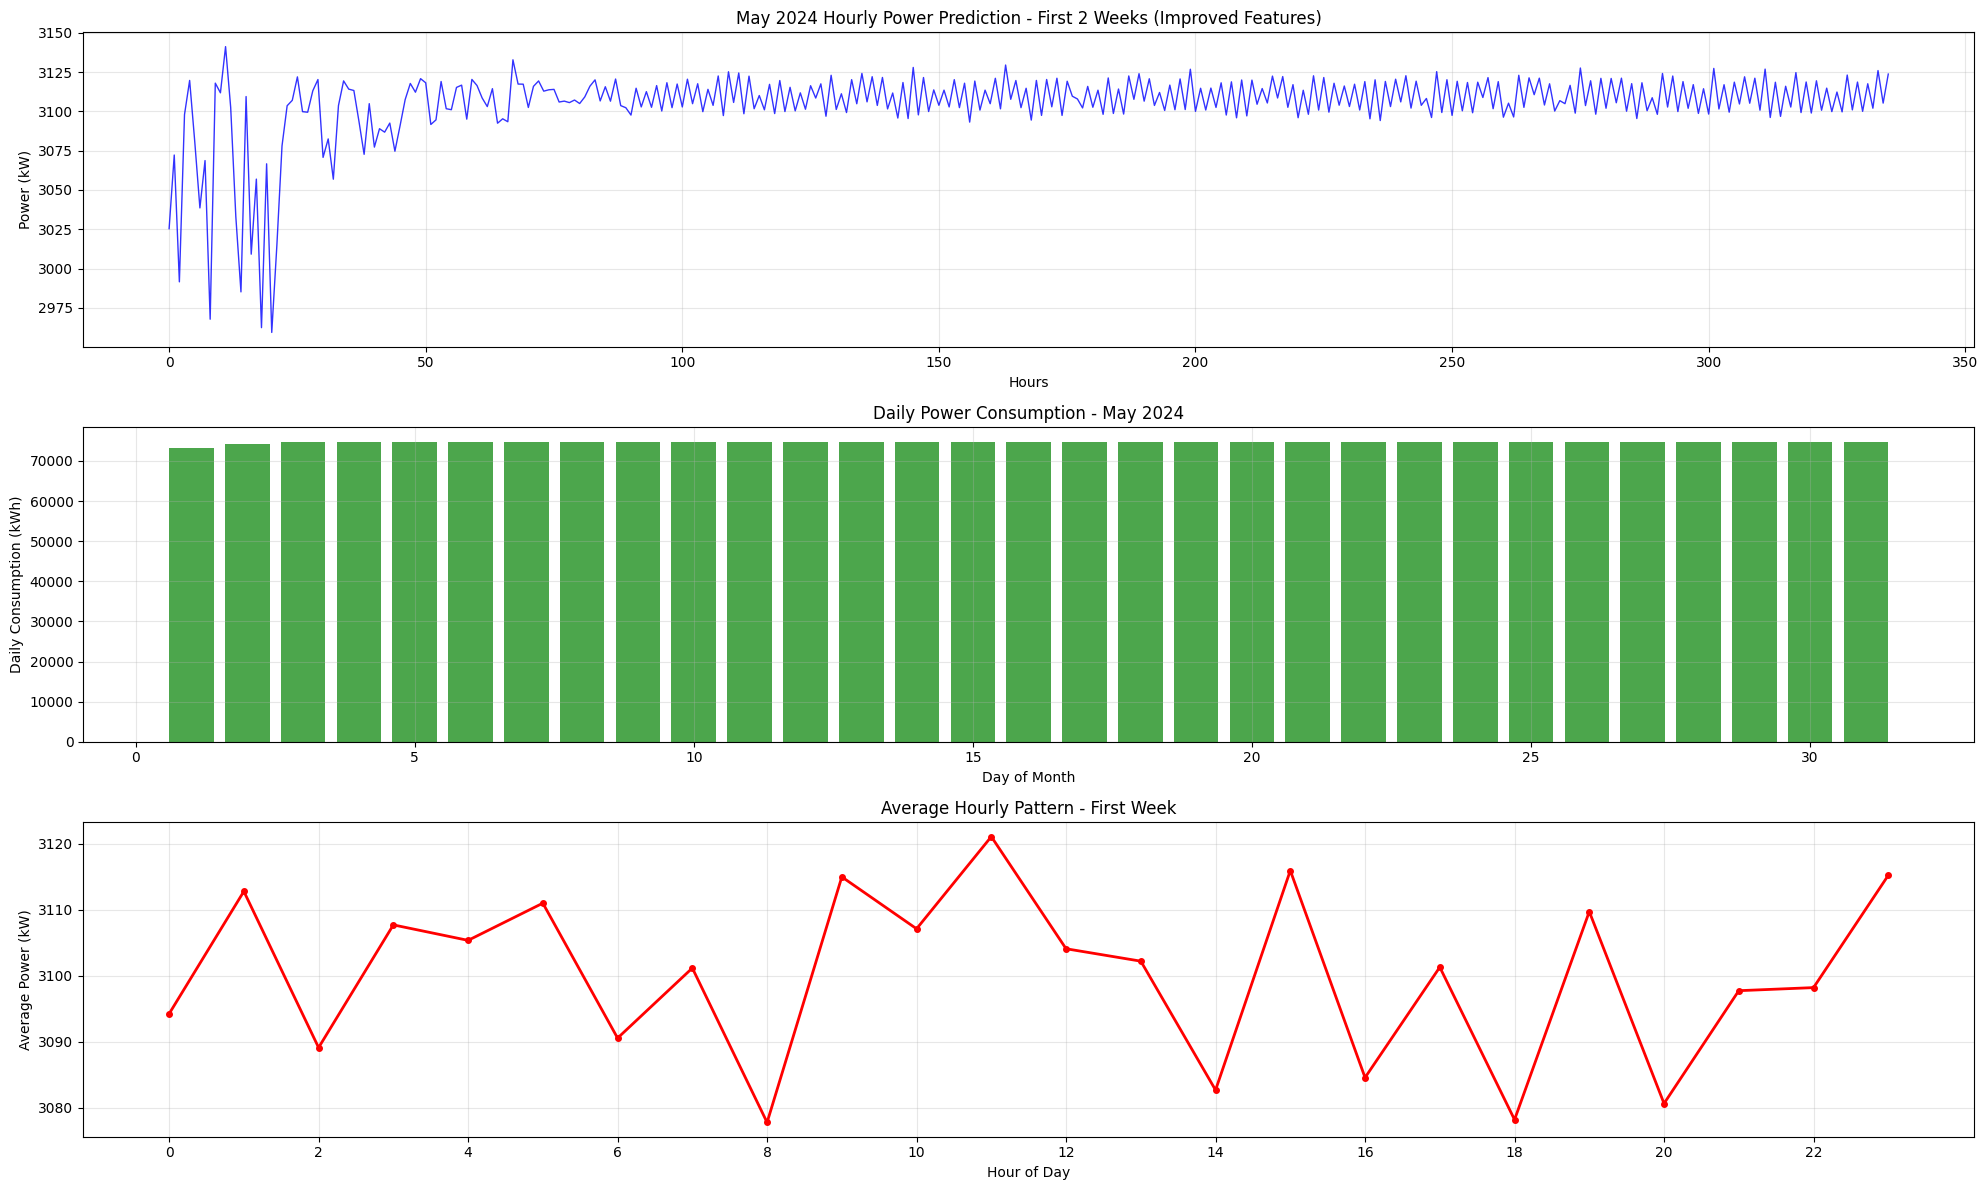

Visualization saved: may_2024_two_stage_prediction_improved.png
Two-Stage Prediction with Improved Feature Selection completed


In [2]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Starting Two-Stage Time Series Prediction with Improved Feature Selection")
print("=" * 70)

df = pd.read_csv("/workspace/rtu_data_full.csv")
print(f"df.shape: {df.shape}")
print(f"df.columns: {df.columns.tolist()}")

df_indexed = df.set_index(['timestamp', 'localtime', 'module(equipment)'])
df_wide = df_indexed.unstack('module(equipment)')
print(f"df_wide.shape after unstack: {df_wide.shape}")

df_wide.columns = [f"{col[1][:col[1].index('(')]}_{col[0]}" for col in df_wide.columns]
df_wide = df_wide.reset_index()
print(f"df_wide.shape after reset_index: {df_wide.shape}")
print(f"df_wide.columns: {df_wide.columns.tolist()}")

equipment_list = ['1', '2', '3', '4', '5', '11', '12', '13', '14', '15', '16', '17', '18']
active_power_cols = [f'{eq}_activePower' for eq in equipment_list if f'{eq}_activePower' in df_wide.columns]
print(f"active_power_cols: {active_power_cols}")

df_wide['target_activePower_mean'] = df_wide[active_power_cols].mean(axis=1)
target_col = 'target_activePower_mean'
print(f"target_col: {target_col}")
print(f"target_col min: {df_wide[target_col].min():.2f}")
print(f"target_col max: {df_wide[target_col].max():.2f}")
print(f"target_col mean: {df_wide[target_col].mean():.2f}")

df_wide['datetime'] = pd.to_datetime(df_wide['timestamp'], unit='ms')
df_wide['hour'] = df_wide['datetime'].dt.hour
df_wide['day'] = df_wide['datetime'].dt.day
df_wide['month'] = df_wide['datetime'].dt.month
df_wide['weekday'] = df_wide['datetime'].dt.weekday
df_wide['is_weekend'] = (df_wide['weekday'] >= 5).astype(int)

df_wide = df_wide.sort_values('timestamp').reset_index(drop=True)
print(f"df_wide.shape after sorting: {df_wide.shape}")
print(f"df_wide null count: {df_wide.isnull().sum().sum()}")

df_wide = df_wide.fillna(method='ffill').fillna(method='bfill')
print(f"df_wide null count after fillna: {df_wide.isnull().sum().sum()}")

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    outliers_removed = 0
    
    for col in columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outlier_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            outliers_count = outlier_mask.sum()
            outliers_removed += outliers_count
            
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            
            print(f"{col}: removed {outliers_count} outliers, bounds=[{lower_bound:.2f}, {upper_bound:.2f}]")
    
    print(f"Total outliers removed: {outliers_removed}")
    return df_clean

numeric_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
outlier_cols = [col for col in numeric_cols if col not in ['timestamp', 'localtime', 'hour', 'day', 'month', 'weekday', 'is_weekend']]
print(f"outlier_cols count: {len(outlier_cols)}")

df_wide = remove_outliers_iqr(df_wide, outlier_cols)
print(f"df_wide.shape after outlier removal: {df_wide.shape}")

# ============= 개선된 Feature Selection =============
print("\n" + "="*50)
print("IMPROVED FEATURE SELECTION")
print("="*50)

# activePower 관련 컬럼들을 제외한 feature 후보군 생성
feature_candidates = [col for col in numeric_cols if col not in [
    'timestamp', 'localtime', target_col
] and 'activePower' not in col]  # activePower 포함된 컬럼 모두 제외

print(f"Total feature candidates (excluding activePower): {len(feature_candidates)}")

# 전력 관련 중요 feature 카테고리별 분석
voltage_features = [col for col in feature_candidates if 'voltage' in col.lower()]
current_features = [col for col in feature_candidates if 'current' in col.lower()]
energy_features = [col for col in feature_candidates if 'energy' in col.lower() or 'accumactiveenergy' in col.lower()]
operation_features = [col for col in feature_candidates if 'operation' in col.lower()]
time_features = ['hour', 'day', 'month', 'weekday', 'is_weekend']

print(f"Voltage features: {len(voltage_features)}")
print(f"Current features: {len(current_features)}")
print(f"Energy features: {len(energy_features)}")
print(f"Operation features: {len(operation_features)}")
print(f"Time features: {len(time_features)}")

# 각 카테고리별 상관관계 분석
print("\n--- Correlation Analysis by Feature Type ---")

def analyze_feature_group(group_name, feature_list):
    if len(feature_list) > 0:
        available_features = [f for f in feature_list if f in df_wide.columns]
        if available_features:
            correlations = df_wide[available_features + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
            print(f"\n{group_name} Features (Top 5):")
            for i, (feature, corr) in enumerate(correlations.drop(target_col).head(5).items()):
                print(f"  {i+1}. {feature}: {corr:.4f}")
            return correlations.drop(target_col).head(10).index.tolist()
    return []

voltage_top = analyze_feature_group("Voltage", voltage_features)
current_top = analyze_feature_group("Current", current_features)
energy_top = analyze_feature_group("Energy", energy_features)
operation_top = analyze_feature_group("Operation", operation_features)

# 시간 특성들의 상관관계
time_available = [f for f in time_features if f in df_wide.columns]
time_correlations = df_wide[time_available + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
print(f"\nTime Features:")
for feature, corr in time_correlations.drop(target_col).items():
    print(f"  {feature}: {corr:.4f}")

# 다양한 방법으로 feature selection 수행
print("\n--- Multi-Method Feature Selection ---")

# 1. 상관관계 기반 선택
all_correlations = df_wide[feature_candidates + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
corr_based_features = all_correlations.drop(target_col).head(15).index.tolist()

print(f"\n1. Correlation-based top 15 features:")
for i, feature in enumerate(corr_based_features, 1):
    corr_value = all_correlations[feature]
    print(f"  {i:2d}. {feature}: {corr_value:.4f}")

# 2. 각 카테고리에서 균형잡힌 선택
balanced_features = []
balanced_features.extend(voltage_top[:4])  # 전압 4개
balanced_features.extend(current_top[:4])  # 전류 4개  
balanced_features.extend(energy_top[:3])   # 에너지 3개
balanced_features.extend(operation_top[:2]) # 운영상태 2개
balanced_features.extend(time_available)   # 시간 특성 모두

# 중복 제거
balanced_features = list(dict.fromkeys(balanced_features))
balanced_features = [f for f in balanced_features if f in df_wide.columns]

print(f"\n2. Balanced selection ({len(balanced_features)} features):")
for i, feature in enumerate(balanced_features, 1):
    corr_value = all_correlations.get(feature, 0)
    print(f"  {i:2d}. {feature}: {corr_value:.4f}")

# 3. 상호정보량 기반 선택 (계산 집약적이므로 샘플링)
sample_size = min(10000, len(df_wide))
sample_indices = np.random.choice(len(df_wide), sample_size, replace=False)
df_sample = df_wide.iloc[sample_indices]

print(f"\n3. Mutual Information Analysis (using {sample_size} samples)...")
available_candidates = [f for f in feature_candidates if f in df_sample.columns]
X_sample = df_sample[available_candidates].fillna(0)
y_sample = df_sample[target_col]

mi_scores = mutual_info_regression(X_sample, y_sample, random_state=42)
mi_features = pd.Series(mi_scores, index=available_candidates).sort_values(ascending=False)

print("Mutual Information top 15 features:")
for i, (feature, score) in enumerate(mi_features.head(15).items(), 1):
    print(f"  {i:2d}. {feature}: {score:.4f}")

mi_based_features = mi_features.head(15).index.tolist()

# 4. 최종 feature 조합 생성 (앙상블 방식)
print(f"\n--- Final Feature Selection ---")

# 세 방법의 결과를 종합
final_features = []

# 각 방법에서 상위 features 가져오기
methods_features = {
    'correlation': corr_based_features[:10],
    'balanced': balanced_features[:15],
    'mutual_info': mi_based_features[:10]
}

# 투표 방식으로 feature 선택
feature_votes = {}
for method, features in methods_features.items():
    for i, feature in enumerate(features):
        if feature not in feature_votes:
            feature_votes[feature] = 0
        # 순위에 따른 가중치 부여 (상위일수록 높은 점수)
        feature_votes[feature] += (len(features) - i) / len(features)

# 투표 결과로 정렬
sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)

# 상위 20개 선택하되, 카테고리 균형 고려
top_20_features = []
category_counts = {'voltage': 0, 'current': 0, 'energy': 0, 'operation': 0, 'time': 0, 'other': 0}

for feature, score in sorted_features:
    if len(top_20_features) >= 20:
        break
    
    # 카테고리 판단
    category = 'other'
    if any(x in feature.lower() for x in ['voltage']):
        category = 'voltage'
    elif any(x in feature.lower() for x in ['current']):
        category = 'current'
    elif any(x in feature.lower() for x in ['energy', 'accumactiveenergy']):
        category = 'energy'
    elif any(x in feature.lower() for x in ['operation']):
        category = 'operation'
    elif feature in time_available:
        category = 'time'
    
    # 카테고리별 제한 (너무 한 쪽으로 치우치지 않도록)
    max_per_category = {'voltage': 6, 'current': 6, 'energy': 4, 'operation': 2, 'time': 5, 'other': 3}
    
    if category_counts[category] < max_per_category[category]:
        top_20_features.append(feature)
        category_counts[category] += 1
    elif len(top_20_features) < 18:  # 거의 다 찼을 때는 제한 완화
        top_20_features.append(feature)

print(f"Final Top 20 Features:")
for i, feature in enumerate(top_20_features, 1):
    corr_value = all_correlations.get(feature, 0)
    vote_score = feature_votes.get(feature, 0)
    print(f"  {i:2d}. {feature}: corr={corr_value:.4f}, vote={vote_score:.3f}")

print(f"\nFeature distribution by category:")
for category, count in category_counts.items():
    if count > 0:
        print(f"  {category}: {count} features")

# 기존 코드 계속...
def create_lag_features(data, target_col, window_size=24):
    lag_data = data.copy()
    
    for lag in range(1, window_size + 1):
        lag_data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
    
    lag_data[f'{target_col}_rolling_mean_24'] = data[target_col].rolling(24).mean()
    lag_data[f'{target_col}_rolling_std_24'] = data[target_col].rolling(24).std()
    lag_data[f'{target_col}_rolling_mean_168'] = data[target_col].rolling(168).mean()
    
    return lag_data

def prepare_xy_data(data, target_col, feature_cols, window_size=24):
    data_with_lags = create_lag_features(data, target_col, window_size)
    
    lag_feature_cols = [col for col in data_with_lags.columns if f'{target_col}_lag_' in col or f'{target_col}_rolling_' in col]
    all_feature_cols = feature_cols + lag_feature_cols
    
    clean_data = data_with_lags.dropna()
    
    X = clean_data[all_feature_cols]
    y = clean_data[target_col]
    
    print(f"X.shape: {X.shape}, y.shape: {y.shape}")
    print(f"all_feature_cols count: {len(all_feature_cols)}")
    
    return X, y, clean_data

print("\nSTAGE 1: Training models for each feature")
print("=" * 50)

window_size = 24
feature_models = {}

for i, feature in enumerate(tqdm(top_20_features, desc="Training feature models")):
    print(f"\nTraining model for: {feature} ({i+1}/{len(top_20_features)})")
    
    other_features = [f for f in top_20_features if f != feature]
    X_feat, y_feat, _ = prepare_xy_data(df_wide, feature, other_features, window_size)
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_feat_scaled = scaler_X.fit_transform(X_feat)
    y_feat_scaled = scaler_y.fit_transform(y_feat.values.reshape(-1, 1)).flatten()
    
    print(f"X_feat_scaled.shape: {X_feat_scaled.shape}")
    print(f"y_feat_scaled.shape: {y_feat_scaled.shape}")
    
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='gpu_hist',
        gpu_id=0,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_feat_scaled, y_feat_scaled)
    
    feature_models[feature] = {
        'model': model,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': X_feat.columns.tolist()
    }
    
    if len(X_feat_scaled) > 1000:
        val_pred = model.predict(X_feat_scaled[-1000:])
        val_true = y_feat_scaled[-1000:]
        mae = mean_absolute_error(val_true, val_pred)
        print(f"MAE: {mae:.4f}")

print(f"\nfeature_models keys: {list(feature_models.keys())}")
print("Stage 1 completed")

print("\nSTAGE 2: Training target prediction model")
print("=" * 50)

X_target, y_target, target_data = prepare_xy_data(df_wide, target_col, top_20_features, window_size)

target_scaler_X = MinMaxScaler()
target_scaler_y = MinMaxScaler()

X_target_scaled = target_scaler_X.fit_transform(X_target)
y_target_scaled = target_scaler_y.fit_transform(y_target.values.reshape(-1, 1)).flatten()

print(f"X_target_scaled.shape: {X_target_scaled.shape}")
print(f"y_target_scaled.shape: {y_target_scaled.shape}")

target_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='gpu_hist',
    gpu_id=0,
    random_state=42,
    n_jobs=-1
)

target_model.fit(X_target_scaled, y_target_scaled)

if len(X_target_scaled) > 1000:
    val_pred = target_model.predict(X_target_scaled[-1000:])
    val_true = y_target_scaled[-1000:]
    mae = mean_absolute_error(val_true, val_pred)
    rmse = np.sqrt(mean_squared_error(val_true, val_pred))
    print(f"Target model MAE: {mae:.4f}, RMSE: {rmse:.4f}")

print("Stage 2 completed")

def predict_may_2024_two_stage(feature_models, target_model, target_scaler_X, target_scaler_y, 
                              initial_data, top_20_features, target_col):
    
    may_hours = 31 * 24
    predictions = []
    current_data = initial_data.tail(window_size * 2).copy()
    
    print(f"may_hours: {may_hours}")
    print(f"current_data.shape: {current_data.shape}")
    
    for hour in tqdm(range(may_hours), desc="Predicting May"):
        predicted_features = {}
        
        for feature in top_20_features:
            model_info = feature_models[feature]
            model = model_info['model']
            scaler_X = model_info['scaler_X']
            scaler_y = model_info['scaler_y']
            feature_cols = model_info['feature_cols']
            
            try:
                available_cols = [col for col in feature_cols if col in current_data.columns]
                if len(available_cols) > 0:
                    X_pred = current_data[available_cols].iloc[-1:].fillna(method='ffill').fillna(0)
                    X_pred_scaled = scaler_X.transform(X_pred)
                    
                    feat_pred_scaled = model.predict(X_pred_scaled)[0]
                    feat_pred = scaler_y.inverse_transform([[feat_pred_scaled]])[0, 0]
                    predicted_features[feature] = feat_pred
                else:
                    predicted_features[feature] = current_data[feature].iloc[-1]
                    
            except Exception as e:
                predicted_features[feature] = current_data[feature].iloc[-1]
        
        try:
            new_row = current_data.iloc[-1:].copy()
            for feature, pred_value in predicted_features.items():
                new_row[feature] = pred_value
            
            last_datetime = current_data['datetime'].iloc[-1]
            new_datetime = last_datetime + pd.Timedelta(hours=1)
            new_row['datetime'] = new_datetime
            new_row['hour'] = new_datetime.hour
            new_row['day'] = new_datetime.day
            new_row['month'] = new_datetime.month
            new_row['weekday'] = new_datetime.weekday()
            new_row['is_weekend'] = int(new_datetime.weekday() >= 5)
            
            for lag in range(1, min(25, len(current_data))):
                if f'{target_col}_lag_{lag}' in new_row.columns:
                    if lag == 1:
                        new_row[f'{target_col}_lag_{lag}'] = current_data[target_col].iloc[-1]
                    else:
                        new_row[f'{target_col}_lag_{lag}'] = current_data[target_col].iloc[-lag]
            
            if len(current_data) >= 24:
                new_row[f'{target_col}_rolling_mean_24'] = current_data[target_col].tail(24).mean()
                new_row[f'{target_col}_rolling_std_24'] = current_data[target_col].tail(24).std()
            if len(current_data) >= 168:
                new_row[f'{target_col}_rolling_mean_168'] = current_data[target_col].tail(168).mean()
            
            target_feature_cols = [col for col in target_scaler_X.feature_names_in_ if col in new_row.columns]
            X_target_pred = new_row[target_feature_cols].fillna(method='ffill').fillna(0)
            X_target_pred_scaled = target_scaler_X.transform(X_target_pred)
            
            target_pred_scaled = target_model.predict(X_target_pred_scaled)[0]
            target_pred = target_scaler_y.inverse_transform([[target_pred_scaled]])[0, 0]
            
            predictions.append(target_pred)
            
            new_row[target_col] = target_pred
            current_data = pd.concat([current_data, new_row], ignore_index=True)
            
            if len(current_data) > window_size * 3:
                current_data = current_data.tail(window_size * 2)
                
        except Exception as e:
            predictions.append(current_data[target_col].iloc[-1])
    
    return np.array(predictions)

print("\nStarting May 2024 Prediction")
print("=" * 50)

may_predictions = predict_may_2024_two_stage(
    feature_models=feature_models,
    target_model=target_model,
    target_scaler_X=target_scaler_X,
    target_scaler_y=target_scaler_y,
    initial_data=target_data,
    top_20_features=top_20_features,
    target_col=target_col
)

print(f"may_predictions.shape: {may_predictions.shape}")
print(f"may_predictions min: {may_predictions.min():.2f}")
print(f"may_predictions max: {may_predictions.max():.2f}")
print(f"may_predictions mean: {may_predictions.mean():.2f}")

total_consumption = may_predictions.sum()
total_bill = total_consumption * 180
total_carbon = total_consumption * 0.424

print(f"total_consumption: {total_consumption:.2f} kWh")
print(f"total_bill: {total_bill:,.0f} won")
print(f"total_carbon: {total_carbon:.2f} kgCO2")

submission_df = pd.DataFrame({
    'hourly_pow': may_predictions,
    'may_bill': [total_bill] * len(may_predictions),
    'may_carbon': [total_carbon] * len(may_predictions)
})

submission_df.to_csv('/workspace/submission_two_stage_improved.csv', index=False)
print("submission_two_stage_improved.csv saved")

plt.figure(figsize=(20, 12))

plt.subplot(3, 1, 1)
first_two_weeks = may_predictions[:336]
plt.plot(range(len(first_two_weeks)), first_two_weeks, 'b-', alpha=0.8, linewidth=1)
plt.title('May 2024 Hourly Power Prediction - First 2 Weeks (Improved Features)')
plt.xlabel('Hours')
plt.ylabel('Power (kW)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
daily_consumption = may_predictions.reshape(-1, 24).sum(axis=1)
plt.bar(range(1, len(daily_consumption) + 1), daily_consumption, alpha=0.7, color='green')
plt.title('Daily Power Consumption - May 2024')
plt.xlabel('Day of Month')
plt.ylabel('Daily Consumption (kWh)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
weekly_pattern = may_predictions[:168].reshape(-1, 24).mean(axis=0)
plt.plot(range(24), weekly_pattern, 'ro-', linewidth=2, markersize=4)
plt.title('Average Hourly Pattern - First Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('may_2024_two_stage_prediction_improved.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: may_2024_two_stage_prediction_improved.png")
print("Two-Stage Prediction with Improved Feature Selection completed")

전력 소비 예측 모델 - 2025년 5월 예측
원본 데이터 형태: (33696013, 19)
컬럼들: ['module(equipment)', 'timestamp', 'localtime', 'operation', 'voltageR', 'voltageS', 'voltageT', 'voltageRS', 'voltageST', 'voltageTR', 'currentR', 'currentS', 'currentT', 'activePower', 'powerFactorR', 'powerFactorS', 'powerFactorT', 'reactivePowerLagging', 'accumActiveEnergy']

데이터 헤드:
  module(equipment)      timestamp       localtime  operation  voltageR  \
0           1(PM-3)  1733040000000  20241201000000          1    214.38   
1           1(PM-3)  1733040005000  20241201000005          1    214.05   
2           1(PM-3)  1733040010000  20241201000010          1    215.79   
3           1(PM-3)  1733040015000  20241201000015          1    210.39   
4           1(PM-3)  1733040020000  20241201000020          1    216.71   

   voltageS  voltageT  voltageRS  voltageST  voltageTR  currentR  currentS  \
0    214.45    219.10     371.37     375.45     375.39     15.16     15.53   
1    211.74    218.68     368.73     372.74    

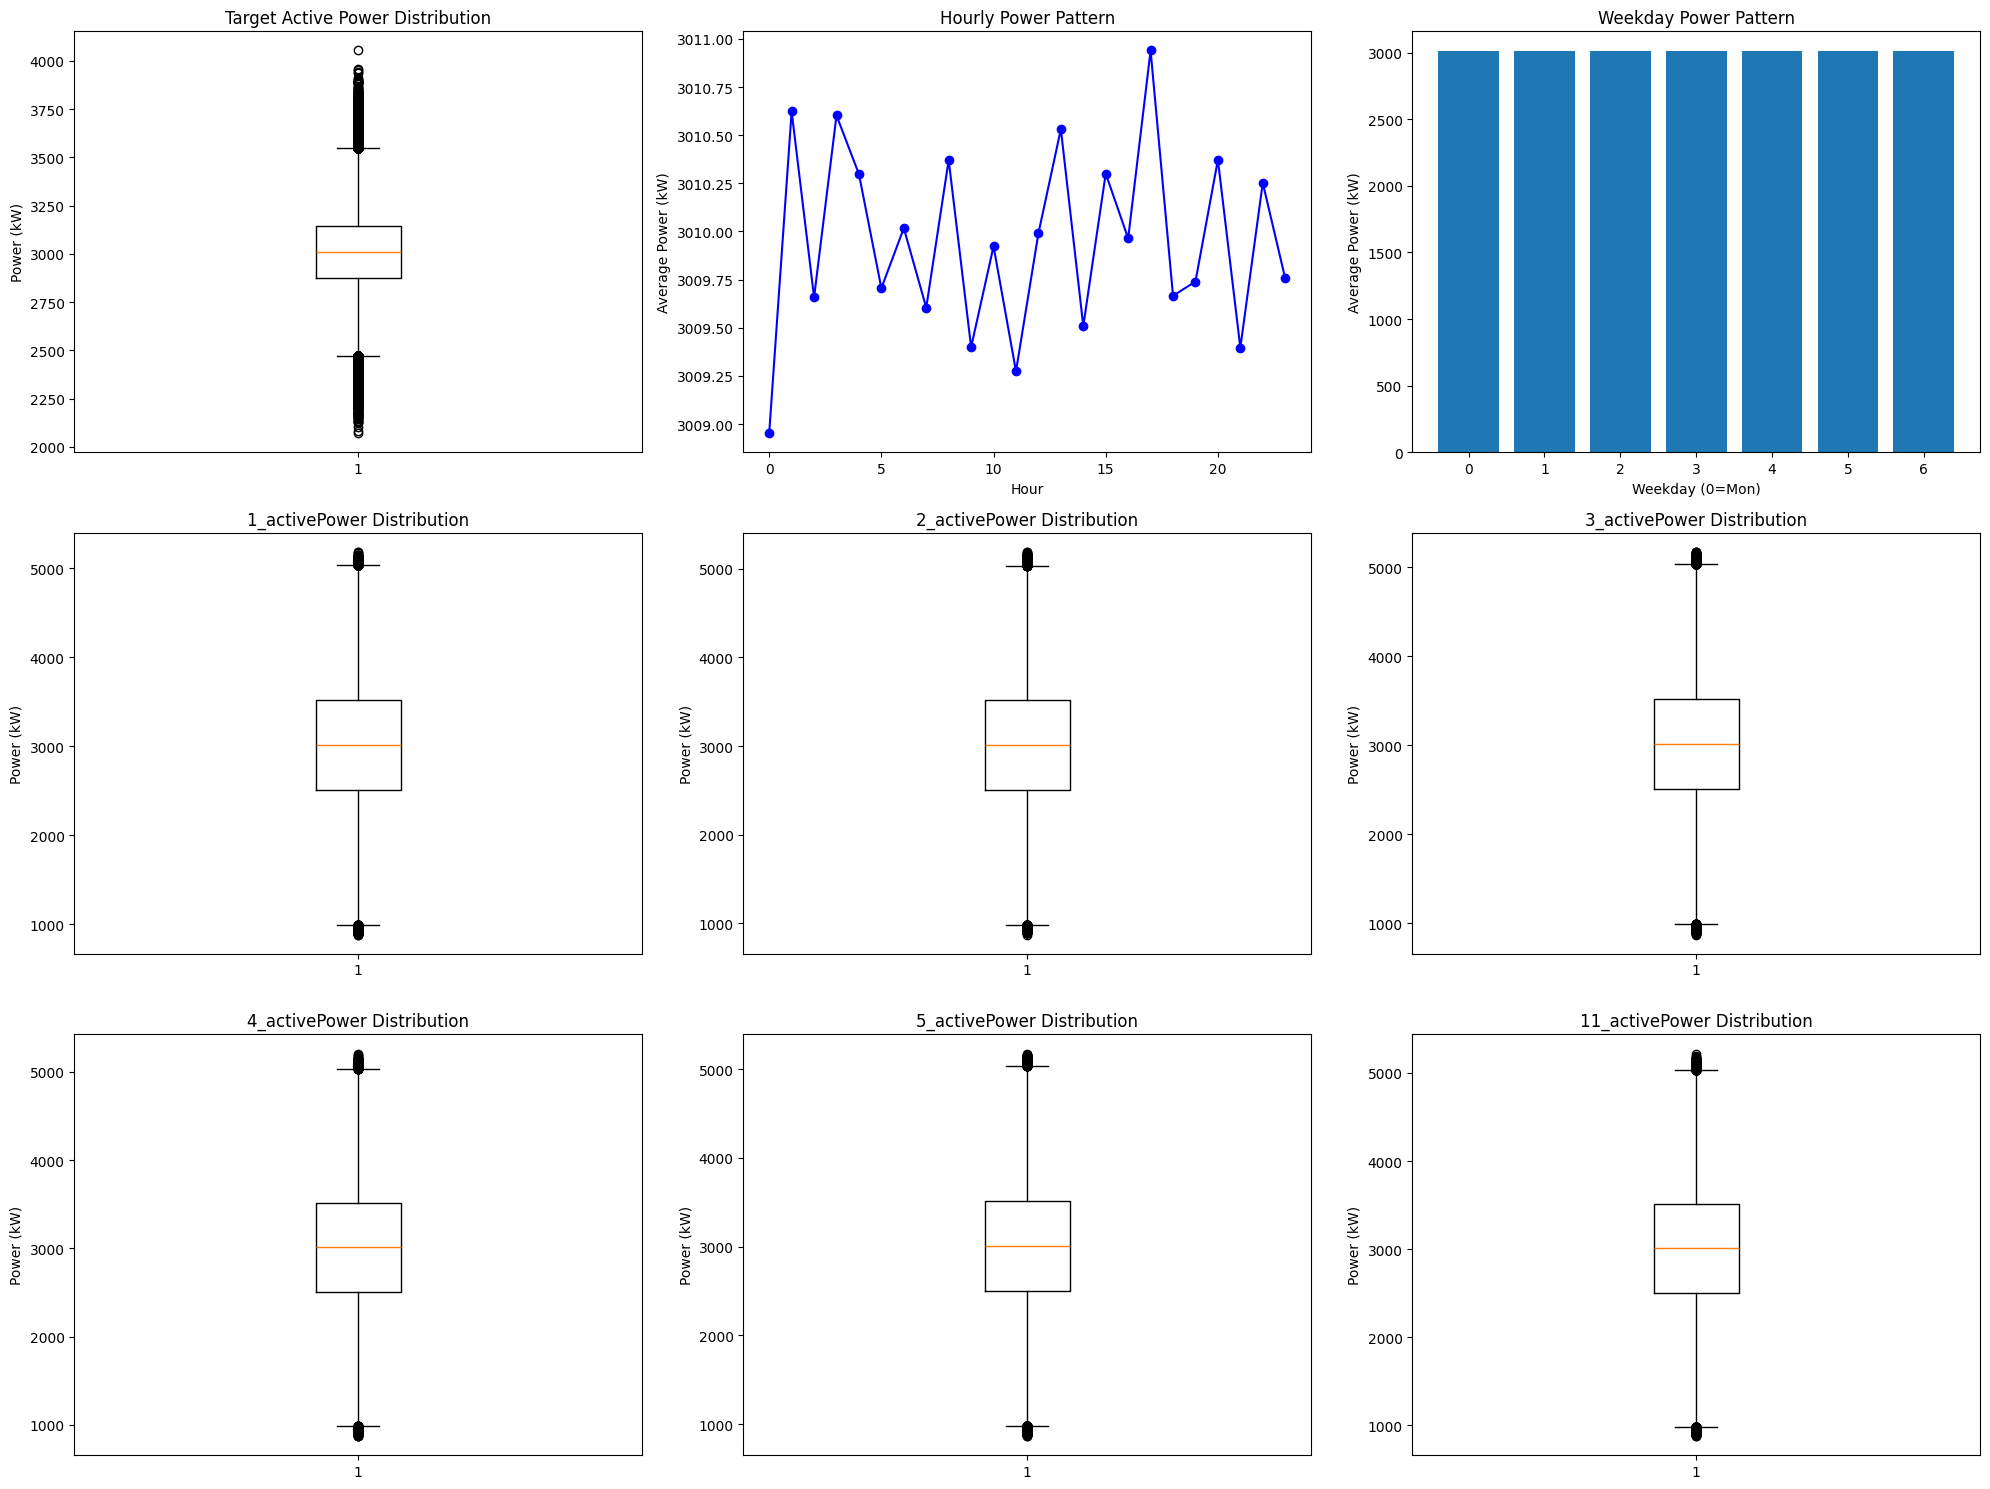


이상치 제거할 컬럼 개수: 209
13_voltageR: 제거된 이상치 11395개, 범위=[204.93, 225.01]
13_voltageS: 제거된 이상치 11384개, 범위=[204.92, 225.04]
13_voltageT: 제거된 이상치 11354개, 범위=[204.94, 225.02]
13_voltageRS: 제거된 이상치 13048개, 범위=[362.13, 382.56]
13_voltageST: 제거된 이상치 13048개, 범위=[362.13, 382.58]
13_voltageTR: 제거된 이상치 13048개, 범위=[362.13, 382.56]
1_activePower: 제거된 이상치 745개, 범위=[988.80, 5032.51]
11_activePower: 제거된 이상치 678개, 범위=[985.41, 5033.70]
12_activePower: 제거된 이상치 653개, 범위=[985.35, 5034.55]
13_activePower: 제거된 이상치 683개, 범위=[986.02, 5031.22]
14_activePower: 제거된 이상치 677개, 범위=[985.51, 5034.51]
15_activePower: 제거된 이상치 672개, 범위=[986.24, 5033.84]
16_activePower: 제거된 이상치 630개, 범위=[984.16, 5035.12]
17_activePower: 제거된 이상치 649개, 범위=[985.40, 5034.36]
18_activePower: 제거된 이상치 686개, 범위=[986.52, 5033.64]
2_activePower: 제거된 이상치 640개, 범위=[984.12, 5034.81]
3_activePower: 제거된 이상치 685개, 범위=[986.88, 5031.95]
4_activePower: 제거된 이상치 629개, 범위=[986.54, 5034.91]
5_activePower: 제거된 이상치 610개, 범위=[983.28, 5036.85]
15_powerFactorR: 제거된 이상치 

특성별 모델 훈련:   0%|          | 0/25 [00:00<?, ?it/s]


15_currentR 모델 훈련 중... (1/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:   4%|▍         | 1/25 [00:09<03:45,  9.41s/it]

  검증 MAE: 0.2459

2_currentT 모델 훈련 중... (2/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:   8%|▊         | 2/25 [00:19<03:39,  9.55s/it]

  검증 MAE: 0.2418

3_currentT 모델 훈련 중... (3/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  12%|█▏        | 3/25 [00:27<03:15,  8.89s/it]

  검증 MAE: 0.2414

16_currentS 모델 훈련 중... (4/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  16%|█▌        | 4/25 [00:35<03:00,  8.61s/it]

  검증 MAE: 0.2504

3_currentS 모델 훈련 중... (5/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  20%|██        | 5/25 [00:43<02:47,  8.35s/it]

  검증 MAE: 0.2492

16_currentR 모델 훈련 중... (6/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  24%|██▍       | 6/25 [00:51<02:36,  8.22s/it]

  검증 MAE: 0.2415

11_voltageRS 모델 훈련 중... (7/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  28%|██▊       | 7/25 [00:59<02:26,  8.15s/it]

  검증 MAE: 0.1486

5_currentT 모델 훈련 중... (8/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  32%|███▏      | 8/25 [01:07<02:17,  8.08s/it]

  검증 MAE: 0.2515

5_voltageRS 모델 훈련 중... (9/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  36%|███▌      | 9/25 [01:15<02:08,  8.06s/it]

  검증 MAE: 0.1309

12_currentR 모델 훈련 중... (10/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  40%|████      | 10/25 [01:23<02:01,  8.10s/it]

  검증 MAE: 0.2346

12_voltageTR 모델 훈련 중... (11/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  44%|████▍     | 11/25 [01:31<01:53,  8.07s/it]

  검증 MAE: 0.1459

11_currentR 모델 훈련 중... (12/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  48%|████▊     | 12/25 [01:39<01:44,  8.00s/it]

  검증 MAE: 0.2385

5_currentS 모델 훈련 중... (13/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  52%|█████▏    | 13/25 [01:47<01:35,  7.97s/it]

  검증 MAE: 0.2544

5_voltageST 모델 훈련 중... (14/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  56%|█████▌    | 14/25 [01:55<01:29,  8.14s/it]

  검증 MAE: 0.1216

11_voltageTR 모델 훈련 중... (15/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  60%|██████    | 15/25 [02:03<01:21,  8.13s/it]

  검증 MAE: 0.1430

18_currentT 모델 훈련 중... (16/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  64%|██████▍   | 16/25 [02:11<01:12,  8.03s/it]

  검증 MAE: 0.2436

4_voltageTR 모델 훈련 중... (17/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  68%|██████▊   | 17/25 [02:19<01:03,  7.98s/it]

  검증 MAE: 0.1651

17_currentR 모델 훈련 중... (18/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  72%|███████▏  | 18/25 [02:27<00:56,  8.04s/it]

  검증 MAE: 0.2502

12_voltageRS 모델 훈련 중... (19/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  76%|███████▌  | 19/25 [02:35<00:48,  8.07s/it]

  검증 MAE: 0.1435

14_currentR 모델 훈련 중... (20/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  80%|████████  | 20/25 [02:43<00:40,  8.06s/it]

  검증 MAE: 0.2544

5_currentR 모델 훈련 중... (21/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  84%|████████▍ | 21/25 [02:51<00:32,  8.09s/it]

  검증 MAE: 0.2429

5_voltageTR 모델 훈련 중... (22/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  88%|████████▊ | 22/25 [03:00<00:24,  8.12s/it]

  검증 MAE: 0.1189

minute 모델 훈련 중... (23/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  92%|█████████▏| 23/25 [03:07<00:15,  7.88s/it]

  검증 MAE: 0.0000

5_powerFactorT 모델 훈련 중... (24/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련:  96%|█████████▌| 24/25 [03:15<00:07,  7.93s/it]

  검증 MAE: 0.2455

14_accumActiveEnergy 모델 훈련 중... (25/25)
X 형태: (2574722, 33), y 형태: (2574722,)
전체 특성 개수: 33


특성별 모델 훈련: 100%|██████████| 25/25 [03:23<00:00,  8.14s/it]

  검증 MAE: 0.0014

훈련된 특성 모델: 25개

2단계: 타겟 예측 모델 훈련


X 형태: (2574722, 34), y 형태: (2574722,)
전체 특성 개수: 34
타겟 모델 데이터 형태: X=(2574722, 34), y=(2574722,)
타겟 모델 MAE: 0.1165, RMSE: 0.1434

2025년 5월 예측 시작
2025년 5월 744시간 예측 시작...
시간당 레코드 수: 720개


5월 시간별 예측:   5%|▍         | 37/744 [28:21<9:01:46, 45.98s/it]


KeyboardInterrupt: 

In [5]:
!pip install seaborn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 134.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 164.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


Starting Two-Stage Time Series Prediction with Improved Feature Selection
df.shape: (33696013, 19)
df.columns: ['module(equipment)', 'timestamp', 'localtime', 'operation', 'voltageR', 'voltageS', 'voltageT', 'voltageRS', 'voltageST', 'voltageTR', 'currentR', 'currentS', 'currentT', 'activePower', 'powerFactorR', 'powerFactorS', 'powerFactorT', 'reactivePowerLagging', 'accumActiveEnergy']

DATA EXPLORATION

--- Dataset Head ---
  module(equipment)      timestamp       localtime  operation  voltageR  \
0           1(PM-3)  1733040000000  20241201000000          1    214.38   
1           1(PM-3)  1733040005000  20241201000005          1    214.05   
2           1(PM-3)  1733040010000  20241201000010          1    215.79   
3           1(PM-3)  1733040015000  20241201000015          1    210.39   
4           1(PM-3)  1733040020000  20241201000020          1    216.71   

   voltageS  voltageT  voltageRS  voltageST  voltageTR  currentR  currentS  \
0    214.45    219.10     371.37     375

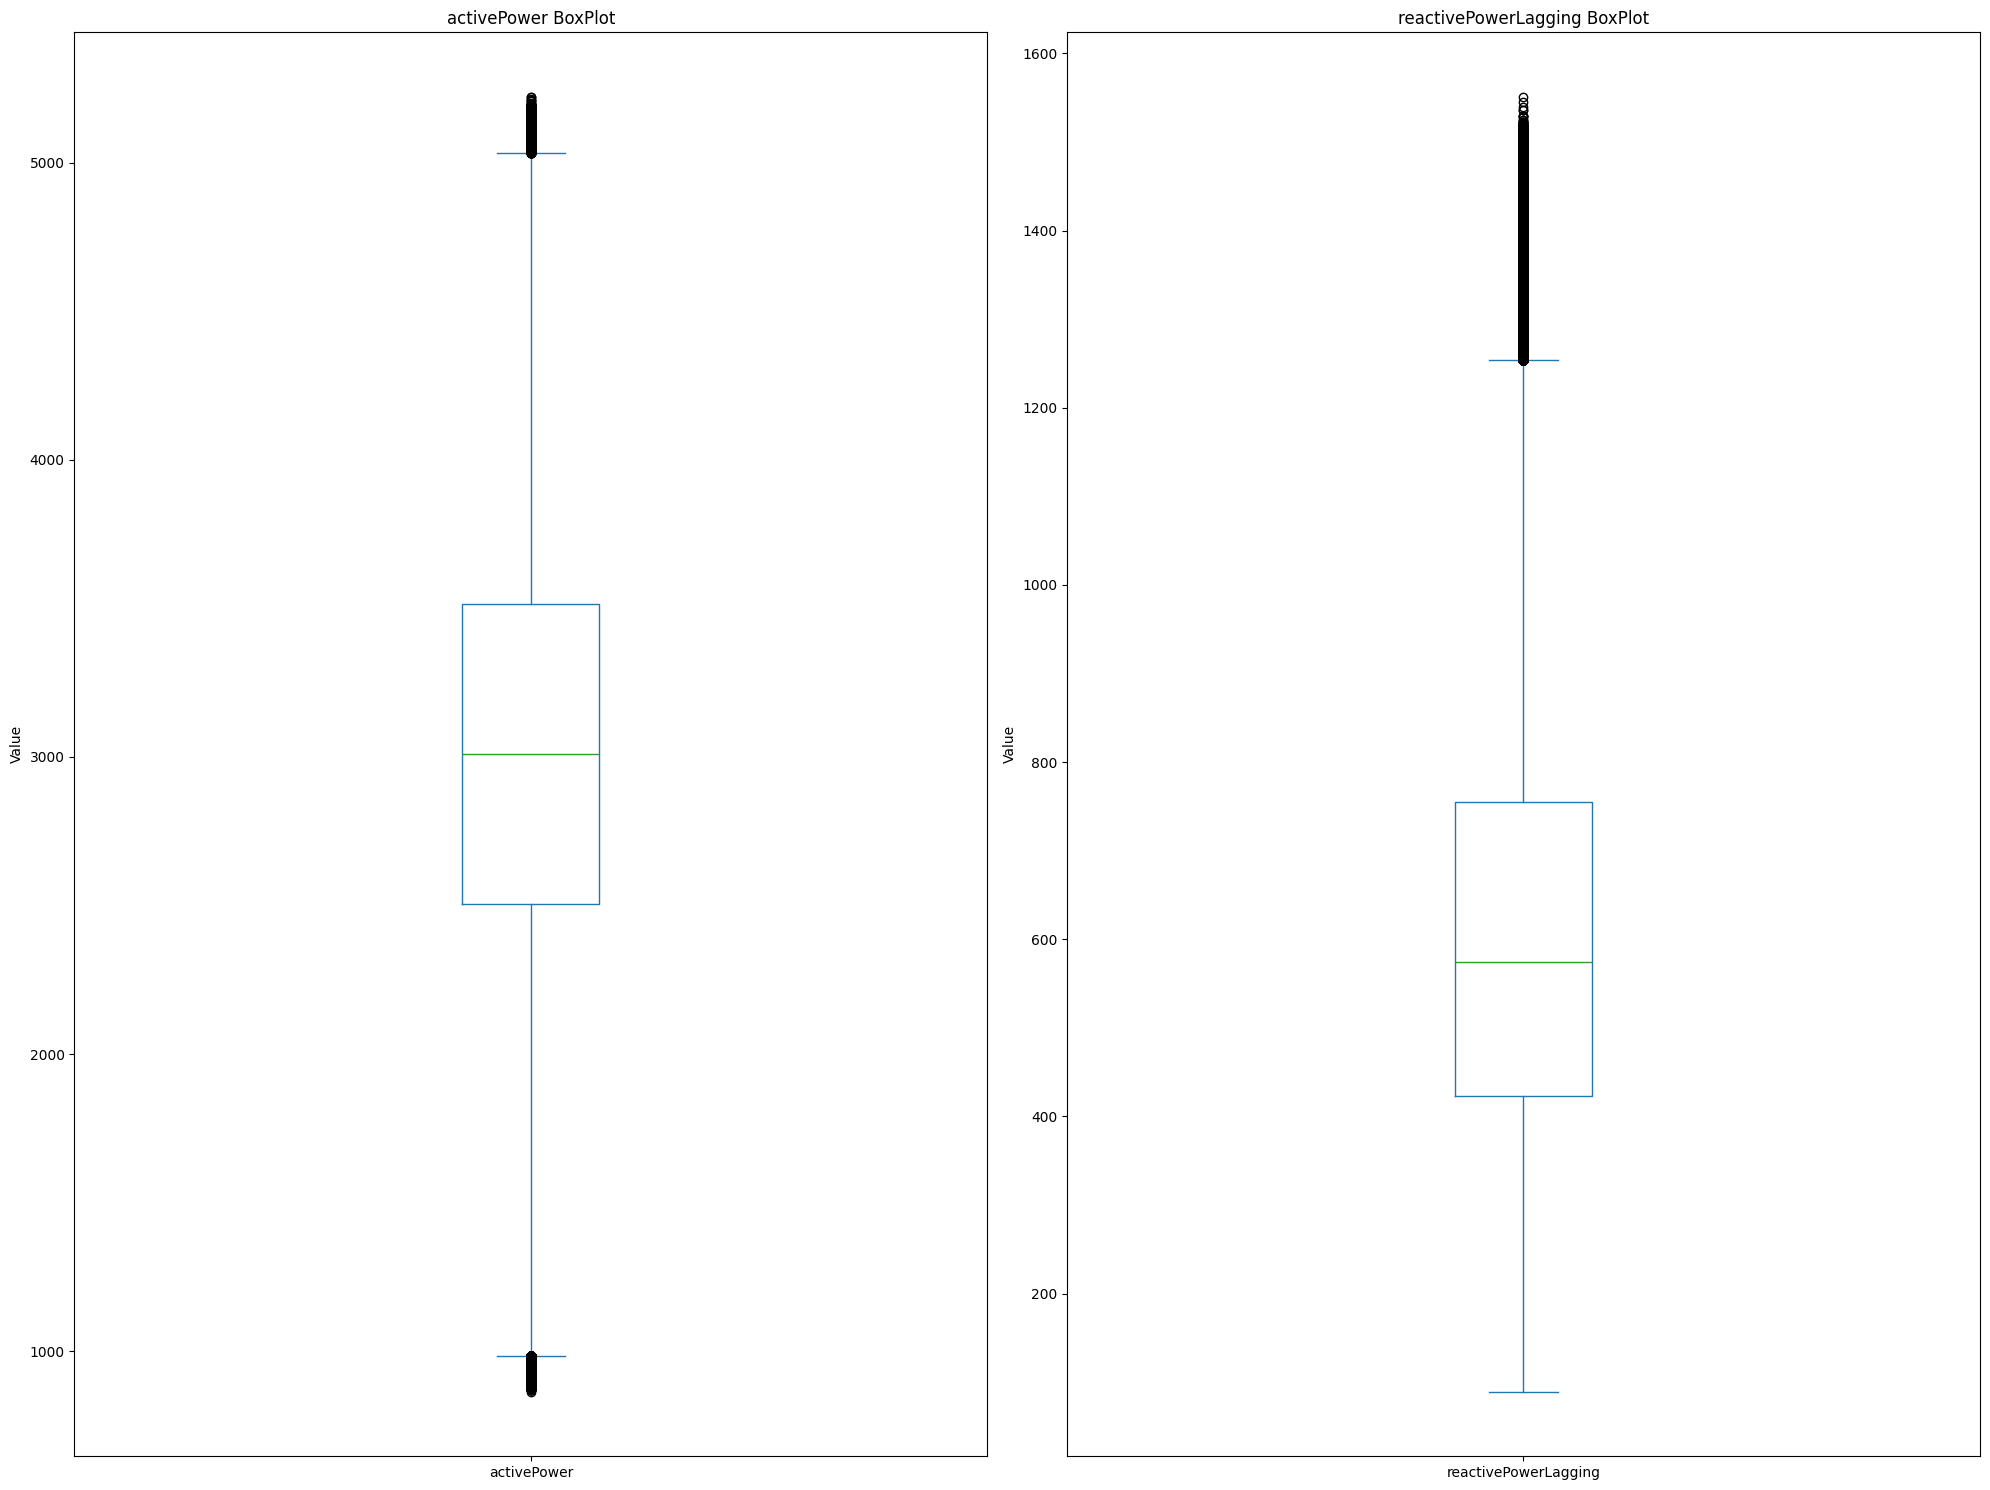

BoxPlots saved: data_boxplots.png
df_wide.shape after unstack: (2592001, 208)
df_wide.shape after reset_index: (2592001, 210)
df_wide.columns: ['timestamp', 'localtime', '1_operation', '11_operation', '12_operation', '13_operation', '14_operation', '15_operation', '16_operation', '17_operation', '18_operation', '2_operation', '3_operation', '4_operation', '5_operation', '1_voltageR', '11_voltageR', '12_voltageR', '13_voltageR', '14_voltageR', '15_voltageR', '16_voltageR', '17_voltageR', '18_voltageR', '2_voltageR', '3_voltageR', '4_voltageR', '5_voltageR', '1_voltageS', '11_voltageS', '12_voltageS', '13_voltageS', '14_voltageS', '15_voltageS', '16_voltageS', '17_voltageS', '18_voltageS', '2_voltageS', '3_voltageS', '4_voltageS', '5_voltageS', '1_voltageT', '11_voltageT', '12_voltageT', '13_voltageT', '14_voltageT', '15_voltageT', '16_voltageT', '17_voltageT', '18_voltageT', '2_voltageT', '3_voltageT', '4_voltageT', '5_voltageT', '1_voltageRS', '11_voltageRS', '12_voltageRS', '13_voltag

Training feature models:   0%|          | 0/39 [00:00<?, ?it/s]


Training model for: 16_currentR (1/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:   3%|▎         | 1/39 [00:15<10:01, 15.84s/it]

MAE: 0.1531

Training model for: 15_currentR (2/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:   5%|▌         | 2/39 [00:33<10:16, 16.66s/it]

MAE: 0.1552

Training model for: 11_currentR (3/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:   8%|▊         | 3/39 [00:49<09:50, 16.39s/it]

MAE: 0.1473

Training model for: 2_currentT (4/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  10%|█         | 4/39 [01:06<09:45, 16.72s/it]

MAE: 0.1552

Training model for: 11_voltageST (5/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  13%|█▎        | 5/39 [01:21<09:14, 16.31s/it]

MAE: 0.0982

Training model for: 3_currentT (6/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  15%|█▌        | 6/39 [01:39<09:08, 16.61s/it]

MAE: 0.1556

Training model for: 16_currentS (7/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  18%|█▊        | 7/39 [01:55<08:44, 16.39s/it]

MAE: 0.1597

Training model for: 3_currentS (8/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  21%|██        | 8/39 [02:12<08:39, 16.75s/it]

MAE: 0.1565

Training model for: 11_voltageRS (9/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  23%|██▎       | 9/39 [02:28<08:11, 16.40s/it]

MAE: 0.1009

Training model for: 5_voltageRS (10/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  26%|██▌       | 10/39 [02:45<08:00, 16.59s/it]

MAE: 0.1022

Training model for: 18_currentR (11/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  28%|██▊       | 11/39 [03:01<07:39, 16.41s/it]

MAE: 0.1652

Training model for: 12_voltageTR (12/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  31%|███       | 12/39 [03:18<07:29, 16.64s/it]

MAE: 0.1056

Training model for: 5_voltageST (13/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  33%|███▎      | 13/39 [03:34<07:04, 16.34s/it]

MAE: 0.0937

Training model for: 12_currentR (14/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  36%|███▌      | 14/39 [03:51<06:56, 16.66s/it]

MAE: 0.1474

Training model for: 14_currentT (15/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  38%|███▊      | 15/39 [04:07<06:34, 16.46s/it]

MAE: 0.1550

Training model for: 11_voltageTR (16/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  41%|████      | 16/39 [04:23<06:17, 16.42s/it]

MAE: 0.0982

Training model for: 18_currentT (17/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  44%|████▎     | 17/39 [04:39<05:58, 16.28s/it]

MAE: 0.1560

Training model for: 4_voltageTR (18/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  46%|████▌     | 18/39 [04:55<05:40, 16.21s/it]

MAE: 0.0959

Training model for: 12_voltageRS (19/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  49%|████▊     | 19/39 [05:11<05:21, 16.10s/it]

MAE: 0.1051

Training model for: 5_currentR (20/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  51%|█████▏    | 20/39 [05:28<05:07, 16.20s/it]

MAE: 0.1527

Training model for: 5_voltageTR (21/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  54%|█████▍    | 21/39 [05:43<04:49, 16.07s/it]

MAE: 0.0922

Training model for: 4_voltageRS (22/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  56%|█████▋    | 22/39 [05:59<04:32, 16.04s/it]

MAE: 0.0937

Training model for: 16_currentT (23/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  59%|█████▉    | 23/39 [06:15<04:16, 16.05s/it]

MAE: 0.1544

Training model for: 17_currentS (24/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  62%|██████▏   | 24/39 [06:32<04:01, 16.12s/it]

MAE: 0.1501

Training model for: 13_voltageRS (25/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  64%|██████▍   | 25/39 [06:48<03:44, 16.05s/it]

MAE: 0.0982

Training model for: 2_voltageTR (26/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  67%|██████▋   | 26/39 [07:03<03:27, 15.96s/it]

MAE: 0.1116

Training model for: 15_voltageST (27/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  69%|██████▉   | 27/39 [07:19<03:10, 15.84s/it]

MAE: 0.1109

Training model for: 14_currentR (28/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  72%|███████▏  | 28/39 [07:36<02:57, 16.15s/it]

MAE: 0.1622

Training model for: 13_voltageST (29/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  74%|███████▍  | 29/39 [07:51<02:40, 16.00s/it]

MAE: 0.0990

Training model for: 1_currentS (30/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  77%|███████▋  | 30/39 [08:08<02:25, 16.13s/it]

MAE: 0.1620

Training model for: 18_currentS (31/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  79%|███████▉  | 31/39 [08:24<02:08, 16.08s/it]

MAE: 0.1587

Training model for: 13_currentT (32/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  82%|████████▏ | 32/39 [08:40<01:52, 16.09s/it]

MAE: 0.1619

Training model for: 4_voltageST (33/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  85%|████████▍ | 33/39 [08:56<01:35, 15.96s/it]

MAE: 0.0959

Training model for: 11_currentS (34/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  87%|████████▋ | 34/39 [09:12<01:20, 16.11s/it]

MAE: 0.1531

Training model for: 13_currentR (35/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  90%|████████▉ | 35/39 [09:28<01:04, 16.08s/it]

MAE: 0.1585

Training model for: 16_voltageST (36/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  92%|█████████▏| 36/39 [09:44<00:47, 15.99s/it]

MAE: 0.1082

Training model for: 15_currentS (37/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  95%|█████████▍| 37/39 [10:00<00:31, 15.99s/it]

MAE: 0.1626

Training model for: 17_powerFactorR (38/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models:  97%|█████████▋| 38/39 [10:16<00:16, 16.08s/it]

MAE: 0.1051

Training model for: 1_powerFactorS (39/39)
X.shape: (2591902, 61), y.shape: (2591902,)
all_feature_cols count: 61
X_feat_scaled.shape: (2591902, 61)
y_feat_scaled.shape: (2591902,)


Training feature models: 100%|██████████| 39/39 [10:32<00:00, 16.22s/it]

MAE: 0.1622

feature_models keys: ['16_currentR', '15_currentR', '11_currentR', '2_currentT', '11_voltageST', '3_currentT', '16_currentS', '3_currentS', '11_voltageRS', '5_voltageRS', '18_currentR', '12_voltageTR', '5_voltageST', '12_currentR', '14_currentT', '11_voltageTR', '18_currentT', '4_voltageTR', '12_voltageRS', '5_currentR', '5_voltageTR', '4_voltageRS', '16_currentT', '17_currentS', '13_voltageRS', '2_voltageTR', '15_voltageST', '14_currentR', '13_voltageST', '1_currentS', '18_currentS', '13_currentT', '4_voltageST', '11_currentS', '13_currentR', '16_voltageST', '15_currentS', '17_powerFactorR', '1_powerFactorS']
Stage 1 completed

STAGE 2: Training target prediction model


X.shape: (2591902, 62), y.shape: (2591902,)
all_feature_cols count: 62
X_target_scaled.shape: (2591902, 62)
y_target_scaled.shape: (2591902,)
Target model MAE: 0.0739, RMSE: 0.0928
Stage 2 completed

Starting May 2025 Prediction
may_hours: 672
current_data.shape: (40, 240)


Predicting May 2025: 100%|██████████| 672/672 [01:15<00:00,  8.91it/s]


may_predictions.shape: (672,)
may_predictions min: 2878.04
may_predictions max: 3026.66
may_predictions mean: 2967.28
total_consumption: 1994012.23 kWh
total_bill: 358,922,202 won
total_carbon: 845461.19 kgCO2
submission_two_stage_improved.csv saved
Submission file shape: (672, 5)
Submission file columns: ['id', 'hourly_pow', 'agg_pow', 'may_bill', 'may_carbon']

Submission file head:
                    id   hourly_pow       agg_pow      may_bill     may_carbon
0  2025-05-01 00:00:00  3026.658201  1.994012e+06  3.589222e+08  845461.186434
1  2025-05-01 01:00:00  2976.620934  1.994012e+06  3.589222e+08  845461.186434
2  2025-05-01 02:00:00  2926.212543  1.994012e+06  3.589222e+08  845461.186434
3  2025-05-01 03:00:00  2950.240239  1.994012e+06  3.589222e+08  845461.186434
4  2025-05-01 04:00:00  2878.042510  1.994012e+06  3.589222e+08  845461.186434


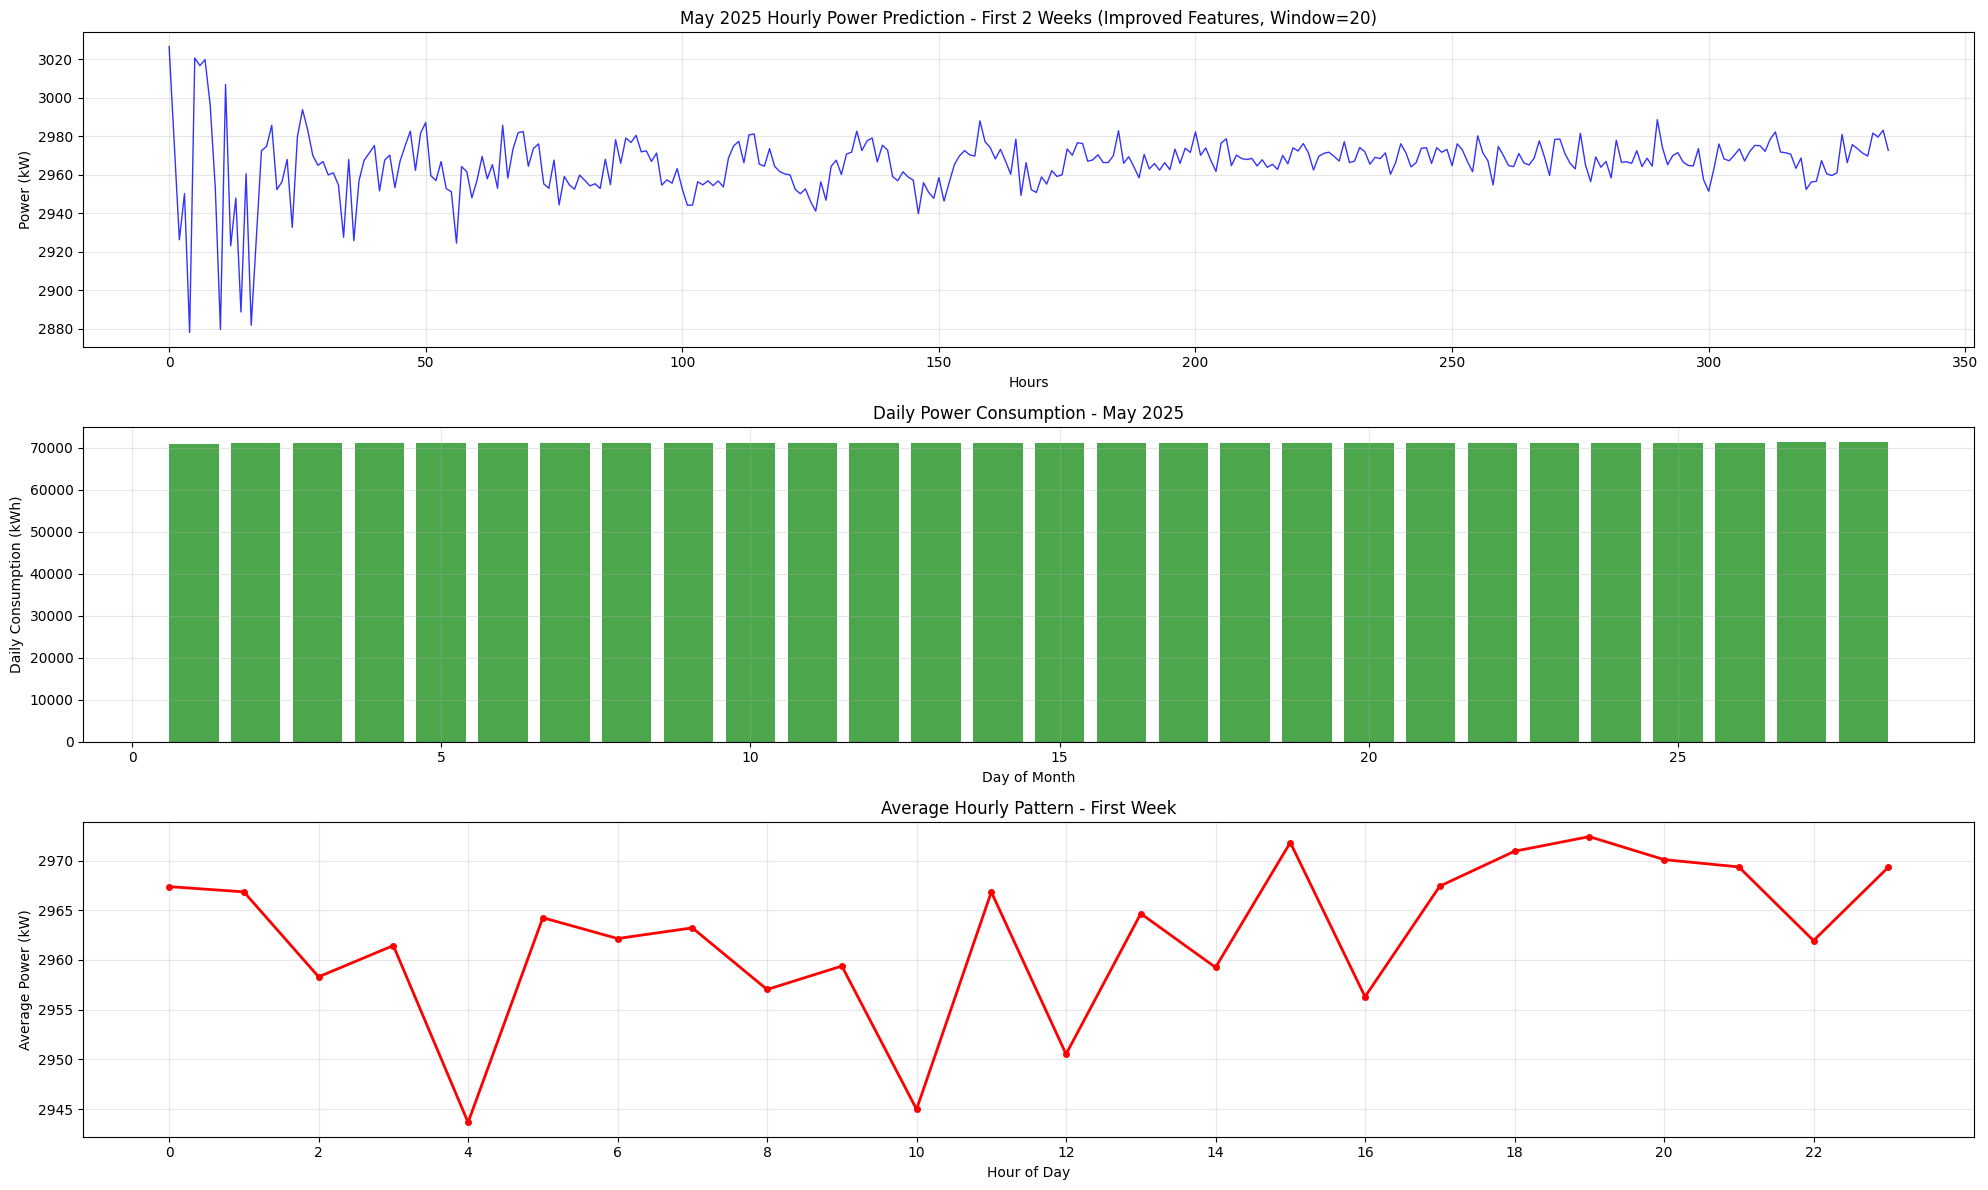

Visualization saved: may_2025_two_stage_prediction_improved.png
Two-Stage Prediction with Improved Feature Selection completed


In [7]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Starting Two-Stage Time Series Prediction with Improved Feature Selection")
print("=" * 70)

# 데이터 로딩 및 기본 정보 확인
df = pd.read_csv("/workspace/rtu_data_full.csv")
print(f"df.shape: {df.shape}")
print(f"df.columns: {df.columns.tolist()}")

# ============= 데이터 head 및 boxplot 확인 =============
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

print("\n--- Dataset Head ---")
print(df.head())

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Statistical Summary ---")
print(df.describe())

# 박스플롯 생성 (주요 컬럼들)
plt.figure(figsize=(20, 15))

# activePower 컬럼들 찾기
active_power_columns = [col for col in df.columns if 'activePower' in col]
print(f"\nActivePower columns found: {active_power_columns}")

if active_power_columns:
    n_cols = min(4, len(active_power_columns))
    n_rows = (len(active_power_columns) + n_cols - 1) // n_cols
    
    for i, col in enumerate(active_power_columns[:12]):  # 최대 12개만 표시
        plt.subplot(n_rows, n_cols, i + 1)
        df[col].dropna().plot(kind='box')
        plt.title(f'{col} BoxPlot')
        plt.ylabel('Value')

plt.tight_layout()
plt.savefig('data_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print("BoxPlots saved: data_boxplots.png")

# 데이터 전처리 계속
df_indexed = df.set_index(['timestamp', 'localtime', 'module(equipment)'])
df_wide = df_indexed.unstack('module(equipment)')
print(f"df_wide.shape after unstack: {df_wide.shape}")

df_wide.columns = [f"{col[1][:col[1].index('(')]}_{col[0]}" for col in df_wide.columns]
df_wide = df_wide.reset_index()
print(f"df_wide.shape after reset_index: {df_wide.shape}")
print(f"df_wide.columns: {df_wide.columns.tolist()}")

equipment_list = ['1', '2', '3', '4', '5', '11', '12', '13', '14', '15', '16', '17', '18']
active_power_cols = [f'{eq}_activePower' for eq in equipment_list if f'{eq}_activePower' in df_wide.columns]
print(f"active_power_cols: {active_power_cols}")

df_wide['target_activePower_mean'] = df_wide[active_power_cols].mean(axis=1)
target_col = 'target_activePower_mean'
print(f"target_col: {target_col}")
print(f"target_col min: {df_wide[target_col].min():.2f}")
print(f"target_col max: {df_wide[target_col].max():.2f}")
print(f"target_col mean: {df_wide[target_col].mean():.2f}")

df_wide['datetime'] = pd.to_datetime(df_wide['timestamp'], unit='ms')
df_wide['hour'] = df_wide['datetime'].dt.hour
df_wide['day'] = df_wide['datetime'].dt.day
df_wide['month'] = df_wide['datetime'].dt.month
df_wide['weekday'] = df_wide['datetime'].dt.weekday
df_wide['is_weekend'] = (df_wide['weekday'] >= 5).astype(int)

df_wide = df_wide.sort_values('timestamp').reset_index(drop=True)
print(f"df_wide.shape after sorting: {df_wide.shape}")
print(f"df_wide null count: {df_wide.isnull().sum().sum()}")

df_wide = df_wide.fillna(method='ffill').fillna(method='bfill')
print(f"df_wide null count after fillna: {df_wide.isnull().sum().sum()}")

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    outliers_removed = 0
    
    for col in columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outlier_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            outliers_count = outlier_mask.sum()
            outliers_removed += outliers_count
            
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            
            print(f"{col}: removed {outliers_count} outliers, bounds=[{lower_bound:.2f}, {upper_bound:.2f}]")
    
    print(f"Total outliers removed: {outliers_removed}")
    return df_clean

numeric_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
outlier_cols = [col for col in numeric_cols if col not in ['timestamp', 'localtime', 'hour', 'day', 'month', 'weekday', 'is_weekend']]
print(f"outlier_cols count: {len(outlier_cols)}")

df_wide = remove_outliers_iqr(df_wide, outlier_cols)
print(f"df_wide.shape after outlier removal: {df_wide.shape}")

# ============= 개선된 Feature Selection (Top 40, operation 제외) =============
print("\n" + "="*50)
print("IMPROVED FEATURE SELECTION (TOP 40, EXCLUDING OPERATION)")
print("="*50)

# activePower 관련 컬럼들과 operation, 시간정보들을 제외한 feature 후보군 생성
feature_candidates = [col for col in numeric_cols if col not in [
    'timestamp', 'localtime', target_col, 'hour', 'day', 'month', 'weekday', 'is_weekend'
] and 'activePower' not in col and 'operation' not in col.lower()]  # operation 제외 추가

print(f"Total feature candidates (excluding activePower and operation): {len(feature_candidates)}")

# 전력 관련 중요 feature 카테고리별 분석
voltage_features = [col for col in feature_candidates if 'voltage' in col.lower()]
current_features = [col for col in feature_candidates if 'current' in col.lower()]
energy_features = [col for col in feature_candidates if 'energy' in col.lower() or 'accumactiveenergy' in col.lower()]

print(f"Voltage features: {len(voltage_features)}")
print(f"Current features: {len(current_features)}")
print(f"Energy features: {len(energy_features)}")

# 각 카테고리별 상관관계 분석
print("\n--- Correlation Analysis by Feature Type ---")

def analyze_feature_group(group_name, feature_list):
    if len(feature_list) > 0:
        available_features = [f for f in feature_list if f in df_wide.columns]
        if available_features:
            correlations = df_wide[available_features + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
            print(f"\n{group_name} Features (Top 10):")
            for i, (feature, corr) in enumerate(correlations.drop(target_col).head(10).items()):
                print(f"  {i+1:2d}. {feature}: {corr:.4f}")
            return correlations.drop(target_col).head(15).index.tolist()
    return []

voltage_top = analyze_feature_group("Voltage", voltage_features)
current_top = analyze_feature_group("Current", current_features)
energy_top = analyze_feature_group("Energy", energy_features)

# 다양한 방법으로 feature selection 수행
print("\n--- Multi-Method Feature Selection ---")

# 1. 상관관계 기반 선택
all_correlations = df_wide[feature_candidates + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
corr_based_features = all_correlations.drop(target_col).head(40).index.tolist()  # Top 40로 변경

print(f"\n1. Correlation-based top 40 features:")
for i, feature in enumerate(corr_based_features, 1):
    corr_value = all_correlations[feature]
    print(f"  {i:2d}. {feature}: {corr_value:.4f}")

# 2. 각 카테고리에서 균형잡힌 선택
balanced_features = []
balanced_features.extend(voltage_top[:15])  # 전압 15개
balanced_features.extend(current_top[:15])  # 전류 15개  
balanced_features.extend(energy_top[:10])   # 에너지 10개

# 중복 제거
balanced_features = list(dict.fromkeys(balanced_features))
balanced_features = [f for f in balanced_features if f in df_wide.columns]

print(f"\n2. Balanced selection ({len(balanced_features)} features):")
for i, feature in enumerate(balanced_features, 1):
    corr_value = all_correlations.get(feature, 0)
    print(f"  {i:2d}. {feature}: {corr_value:.4f}")

# 3. 상호정보량 기반 선택 (계산 집약적이므로 샘플링)
sample_size = min(10000, len(df_wide))
sample_indices = np.random.choice(len(df_wide), sample_size, replace=False)
df_sample = df_wide.iloc[sample_indices]

print(f"\n3. Mutual Information Analysis (using {sample_size} samples)...")
available_candidates = [f for f in feature_candidates if f in df_sample.columns]
X_sample = df_sample[available_candidates].fillna(0)
y_sample = df_sample[target_col]

mi_scores = mutual_info_regression(X_sample, y_sample, random_state=42)
mi_features = pd.Series(mi_scores, index=available_candidates).sort_values(ascending=False)

print("Mutual Information top 40 features:")
for i, (feature, score) in enumerate(mi_features.head(40).items(), 1):
    print(f"  {i:2d}. {feature}: {score:.4f}")

mi_based_features = mi_features.head(40).index.tolist()

# 4. 최종 feature 조합 생성 (앙상블 방식) - Top 40
print(f"\n--- Final Feature Selection (Top 40) ---")

# 세 방법의 결과를 종합
methods_features = {
    'correlation': corr_based_features[:20],
    'balanced': balanced_features[:25],
    'mutual_info': mi_based_features[:20]
}

# 투표 방식으로 feature 선택
feature_votes = {}
for method, features in methods_features.items():
    for i, feature in enumerate(features):
        if feature not in feature_votes:
            feature_votes[feature] = 0
        # 순위에 따른 가중치 부여 (상위일수록 높은 점수)
        feature_votes[feature] += (len(features) - i) / len(features)

# 투표 결과로 정렬
sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)

# 상위 40개 선택
top_40_features = []
category_counts = {'voltage': 0, 'current': 0, 'energy': 0, 'other': 0}

for feature, score in sorted_features:
    if len(top_40_features) >= 40:
        break
    
    # 카테고리 판단
    category = 'other'
    if any(x in feature.lower() for x in ['voltage']):
        category = 'voltage'
    elif any(x in feature.lower() for x in ['current']):
        category = 'current'
    elif any(x in feature.lower() for x in ['energy', 'accumactiveenergy']):
        category = 'energy'
    
    # 카테고리별 제한 (너무 한 쪽으로 치우치지 않도록)
    max_per_category = {'voltage': 15, 'current': 15, 'energy': 8, 'other': 10}
    
    if category_counts[category] < max_per_category[category]:
        top_40_features.append(feature)
        category_counts[category] += 1
    elif len(top_40_features) < 38:  # 거의 다 찼을 때는 제한 완화
        top_40_features.append(feature)

print(f"Final Top 40 Features:")
for i, feature in enumerate(top_40_features, 1):
    corr_value = all_correlations.get(feature, 0)
    vote_score = feature_votes.get(feature, 0)
    print(f"  {i:2d}. {feature}: corr={corr_value:.4f}, vote={vote_score:.3f}")

print(f"\nFeature distribution by category:")
for category, count in category_counts.items():
    if count > 0:
        print(f"  {category}: {count} features")

# ============= Window Size를 20으로 변경 =============
def create_lag_features(data, target_col, window_size=20):  # 20으로 변경
    lag_data = data.copy()
    
    for lag in range(1, window_size + 1):
        lag_data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
    
    lag_data[f'{target_col}_rolling_mean_20'] = data[target_col].rolling(20).mean()  # 20으로 변경
    lag_data[f'{target_col}_rolling_std_20'] = data[target_col].rolling(20).std()   # 20으로 변경
    lag_data[f'{target_col}_rolling_mean_100'] = data[target_col].rolling(100).mean()  # 100으로 변경
    
    return lag_data

def prepare_xy_data(data, target_col, feature_cols, window_size=20):  # 20으로 변경
    data_with_lags = create_lag_features(data, target_col, window_size)
    
    lag_feature_cols = [col for col in data_with_lags.columns if f'{target_col}_lag_' in col or f'{target_col}_rolling_' in col]
    all_feature_cols = feature_cols + lag_feature_cols
    
    clean_data = data_with_lags.dropna()
    
    X = clean_data[all_feature_cols]
    y = clean_data[target_col]
    
    print(f"X.shape: {X.shape}, y.shape: {y.shape}")
    print(f"all_feature_cols count: {len(all_feature_cols)}")
    
    return X, y, clean_data

print("\nSTAGE 1: Training models for each feature")
print("=" * 50)

window_size = 20  # 20으로 변경
feature_models = {}

for i, feature in enumerate(tqdm(top_40_features, desc="Training feature models")):
    print(f"\nTraining model for: {feature} ({i+1}/{len(top_40_features)})")
    
    other_features = [f for f in top_40_features if f != feature]
    X_feat, y_feat, _ = prepare_xy_data(df_wide, feature, other_features, window_size)
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_feat_scaled = scaler_X.fit_transform(X_feat)
    y_feat_scaled = scaler_y.fit_transform(y_feat.values.reshape(-1, 1)).flatten()
    
    print(f"X_feat_scaled.shape: {X_feat_scaled.shape}")
    print(f"y_feat_scaled.shape: {y_feat_scaled.shape}")
    
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='gpu_hist',
        gpu_id=0,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_feat_scaled, y_feat_scaled)
    
    feature_models[feature] = {
        'model': model,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': X_feat.columns.tolist()
    }
    
    if len(X_feat_scaled) > 1000:
        val_pred = model.predict(X_feat_scaled[-1000:])
        val_true = y_feat_scaled[-1000:]
        mae = mean_absolute_error(val_true, val_pred)
        print(f"MAE: {mae:.4f}")

print(f"\nfeature_models keys: {list(feature_models.keys())}")
print("Stage 1 completed")

print("\nSTAGE 2: Training target prediction model")
print("=" * 50)

X_target, y_target, target_data = prepare_xy_data(df_wide, target_col, top_40_features, window_size)

target_scaler_X = MinMaxScaler()
target_scaler_y = MinMaxScaler()

X_target_scaled = target_scaler_X.fit_transform(X_target)
y_target_scaled = target_scaler_y.fit_transform(y_target.values.reshape(-1, 1)).flatten()

print(f"X_target_scaled.shape: {X_target_scaled.shape}")
print(f"y_target_scaled.shape: {y_target_scaled.shape}")

target_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='gpu_hist',
    gpu_id=0,
    random_state=42,
    n_jobs=-1
)

target_model.fit(X_target_scaled, y_target_scaled)

if len(X_target_scaled) > 1000:
    val_pred = target_model.predict(X_target_scaled[-1000:])
    val_true = y_target_scaled[-1000:]
    mae = mean_absolute_error(val_true, val_pred)
    rmse = np.sqrt(mean_squared_error(val_true, val_pred))
    print(f"Target model MAE: {mae:.4f}, RMSE: {rmse:.4f}")

print("Stage 2 completed")

def predict_may_2025_two_stage(feature_models, target_model, target_scaler_X, target_scaler_y, 
                              initial_data, top_40_features, target_col):
    
    # 2025년 5월 1일부터 5월 28일까지 (672시간)
    may_hours = 28 * 24  # 672시간으로 변경
    predictions = []
    current_data = initial_data.tail(window_size * 2).copy()
    
    print(f"may_hours: {may_hours}")
    print(f"current_data.shape: {current_data.shape}")
    
    for hour in tqdm(range(may_hours), desc="Predicting May 2025"):
        predicted_features = {}
        
        for feature in top_40_features:
            model_info = feature_models[feature]
            model = model_info['model']
            scaler_X = model_info['scaler_X']
            scaler_y = model_info['scaler_y']
            feature_cols = model_info['feature_cols']
            
            try:
                available_cols = [col for col in feature_cols if col in current_data.columns]
                if len(available_cols) > 0:
                    X_pred = current_data[available_cols].iloc[-1:].fillna(method='ffill').fillna(0)
                    X_pred_scaled = scaler_X.transform(X_pred)
                    
                    feat_pred_scaled = model.predict(X_pred_scaled)[0]
                    feat_pred = scaler_y.inverse_transform([[feat_pred_scaled]])[0, 0]
                    predicted_features[feature] = feat_pred
                else:
                    predicted_features[feature] = current_data[feature].iloc[-1]
                    
            except Exception as e:
                predicted_features[feature] = current_data[feature].iloc[-1]
        
        try:
            new_row = current_data.iloc[-1:].copy()
            for feature, pred_value in predicted_features.items():
                new_row[feature] = pred_value
            
            # 2025년 5월로 시간 설정
            last_datetime = current_data['datetime'].iloc[-1]
            new_datetime = last_datetime + pd.Timedelta(hours=1)
            new_row['datetime'] = new_datetime
            new_row['hour'] = new_datetime.hour
            new_row['day'] = new_datetime.day
            new_row['month'] = new_datetime.month
            new_row['weekday'] = new_datetime.weekday()
            new_row['is_weekend'] = int(new_datetime.weekday() >= 5)
            
            for lag in range(1, min(21, len(current_data))):  # 20으로 변경
                if f'{target_col}_lag_{lag}' in new_row.columns:
                    if lag == 1:
                        new_row[f'{target_col}_lag_{lag}'] = current_data[target_col].iloc[-1]
                    else:
                        new_row[f'{target_col}_lag_{lag}'] = current_data[target_col].iloc[-lag]
            
            if len(current_data) >= 20:  # 20으로 변경
                new_row[f'{target_col}_rolling_mean_20'] = current_data[target_col].tail(20).mean()
                new_row[f'{target_col}_rolling_std_20'] = current_data[target_col].tail(20).std()
            if len(current_data) >= 100:  # 100으로 변경
                new_row[f'{target_col}_rolling_mean_100'] = current_data[target_col].tail(100).mean()
            
            target_feature_cols = [col for col in target_scaler_X.feature_names_in_ if col in new_row.columns]
            X_target_pred = new_row[target_feature_cols].fillna(method='ffill').fillna(0)
            X_target_pred_scaled = target_scaler_X.transform(X_target_pred)
            
            target_pred_scaled = target_model.predict(X_target_pred_scaled)[0]
            target_pred = target_scaler_y.inverse_transform([[target_pred_scaled]])[0, 0]
            
            predictions.append(target_pred)
            
            new_row[target_col] = target_pred
            current_data = pd.concat([current_data, new_row], ignore_index=True)
            
            if len(current_data) > window_size * 3:
                current_data = current_data.tail(window_size * 2)
                
        except Exception as e:
            predictions.append(current_data[target_col].iloc[-1])
    
    return np.array(predictions)

print("\nStarting May 2025 Prediction")  # 2025년으로 변경
print("=" * 50)

may_predictions = predict_may_2025_two_stage(
    feature_models=feature_models,
    target_model=target_model,
    target_scaler_X=target_scaler_X,
    target_scaler_y=target_scaler_y,
    initial_data=target_data,
    top_40_features=top_40_features,
    target_col=target_col
)

print(f"may_predictions.shape: {may_predictions.shape}")
print(f"may_predictions min: {may_predictions.min():.2f}")
print(f"may_predictions max: {may_predictions.max():.2f}")
print(f"may_predictions mean: {may_predictions.mean():.2f}")

total_consumption = may_predictions.sum()
total_bill = total_consumption * 180
total_carbon = total_consumption * 0.424

print(f"total_consumption: {total_consumption:.2f} kWh")
print(f"total_bill: {total_bill:,.0f} won")
print(f"total_carbon: {total_carbon:.2f} kgCO2")

# ============= 제출 파일 형식 수정 =============
# 시간별 예측값 생성 (2025-05-01 00:00:00부터 672시간)
start_time = pd.Timestamp('2025-05-01 00:00:00')
time_index = pd.date_range(start=start_time, periods=672, freq='H')

submission_df = pd.DataFrame({
    'id': time_index.strftime('%Y-%m-%d %H:%M:%S'),
    'hourly_pow': may_predictions,
    'agg_pow': [total_consumption] * len(may_predictions),  # 모든 행에 동일한 누적값
    'may_bill': [total_bill] * len(may_predictions),
    'may_carbon': [total_carbon] * len(may_predictions)
})

submission_df.to_csv('/workspace/submission_two_stage_improved.csv', index=False)
print("submission_two_stage_improved.csv saved")
print(f"Submission file shape: {submission_df.shape}")
print(f"Submission file columns: {submission_df.columns.tolist()}")
print("\nSubmission file head:")
print(submission_df.head())

plt.figure(figsize=(20, 12))

plt.subplot(3, 1, 1)
first_two_weeks = may_predictions[:336]
plt.plot(range(len(first_two_weeks)), first_two_weeks, 'b-', alpha=0.8, linewidth=1)
plt.title('May 2025 Hourly Power Prediction - First 2 Weeks (Improved Features, Window=20)')
plt.xlabel('Hours')
plt.ylabel('Power (kW)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
daily_consumption = may_predictions.reshape(-1, 24).sum(axis=1)
plt.bar(range(1, len(daily_consumption) + 1), daily_consumption, alpha=0.7, color='green')
plt.title('Daily Power Consumption - May 2025')
plt.xlabel('Day of Month')
plt.ylabel('Daily Consumption (kWh)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
weekly_pattern = may_predictions[:168].reshape(-1, 24).mean(axis=0)
plt.plot(range(24), weekly_pattern, 'ro-', linewidth=2, markersize=4)
plt.title('Average Hourly Pattern - First Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('may_2025_two_stage_prediction_improved.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: may_2025_two_stage_prediction_improved.png")
print("Two-Stage Prediction with Improved Feature Selection completed")